In [2]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [2]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

In [4]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [6]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [7]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [8]:
head(meta_new)

subject_id sample_id time cc  age_d  age_d_s    bf_count bf_count_s  bf_ratio
1 207        sa_10000  post no   98.00  0.0320946 6.00      0.43948544 1       
2 388        sa_10038  post yes  98.00  0.0320946 0.00     -1.65710371 0       
3 381        sa_10118  post yes 108.00  0.5275689 6.59      0.64565004 1       
4 283        sa_10211  post yes 107.03  0.4795079 5.00      0.09005391 1       
5 216        sa_10230  post no  100.00  0.1311895 7.00      0.78891696 1       
6 277        sa_10247  pre  yes  79.00 -0.9093066 6.10      0.47442859 1

In [9]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [10]:
# add confounding variables
confounders <- foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), to.data.frame = T) %>%
    select(ID, SIBLINGS, childsex) %>% rename(sibling = SIBLINGS, subject_id = ID) %>%
    mutate(sibling = ifelse(sibling == "at leat 1 sibling", 1, ifelse(sibling == "firstborn", 0, 1))) %>%
    filter(subject_id %in% meta_new$subject_id)
meta_new <- meta_new %>% left_join(confounders, by = "subject_id")

Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 2 added in variable: SIBLINGS”Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 6, 999 added in variable: DELIVERYmode”

In [11]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PCA

A PCA using CLR transformed values displays the Aitchison distance.

In [15]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")

otus.clr <- otu_to_df(pseq.clr) %>% 
    column_to_rownames("sample_id")
# PCA with CLR values (euclidean distance of clr transformed values = Aitchison distance) 
pcx <- prcomp(otus.clr)
# extract loadings
pcx_rot <- 
    pcx$rotation %>%
        as.tibble() %>%
        mutate_all(function(x) scale(x)[, 1]) %>%
        add_column(genus = rownames(pcx$rotation))

# add PCs to data
princomps <- pcx$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    select(PC1, PC2, PC3, PC4, PC5, sample_id)
data <- data %>% left_join(princomps, by = "sample_id") 
                   
# how much variance do pcs explain?
pc1 <- round(pcx$sdev[1]^2/sum(pcx$sdev^2),2)
pc2 <- round(pcx$sdev[2]^2/sum(pcx$sdev^2),2)
pc3 <- round(pcx$sdev[3]^2/sum(pcx$sdev^2),2)
pc4 <- round(pcx$sdev[4]^2/sum(pcx$sdev^2),2)
pc5 <- round(pcx$sdev[5]^2/sum(pcx$sdev^2),2)                   

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

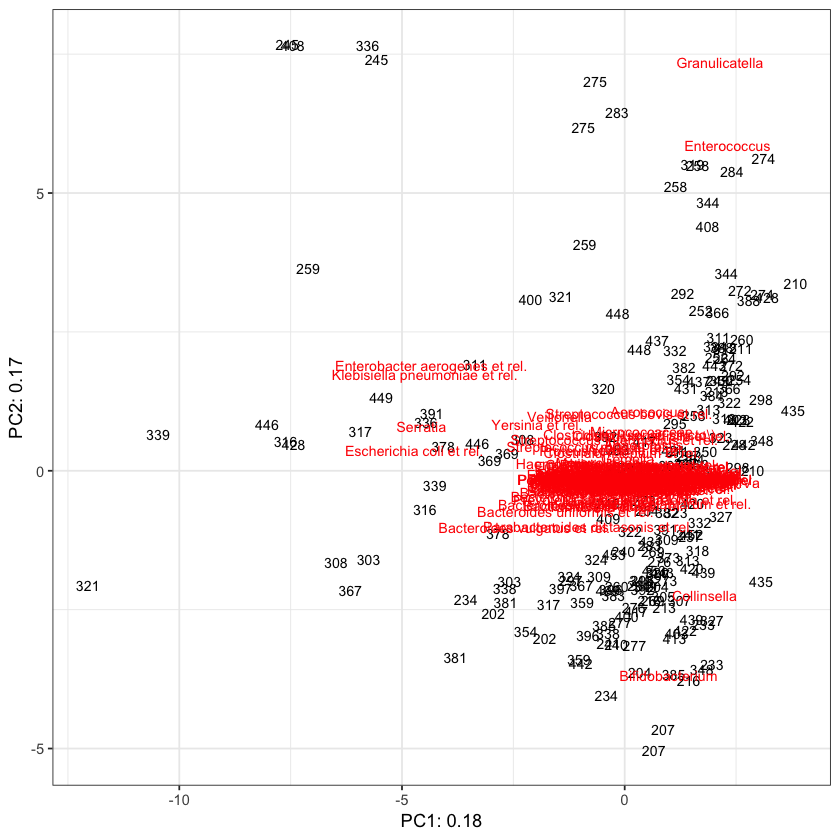

In [16]:
# biplot
data %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_text(size = 3) +
    geom_text(data = pcx_rot, aes(PC1, PC2, label = genus), color = "red", size = 3) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    theme_bw()

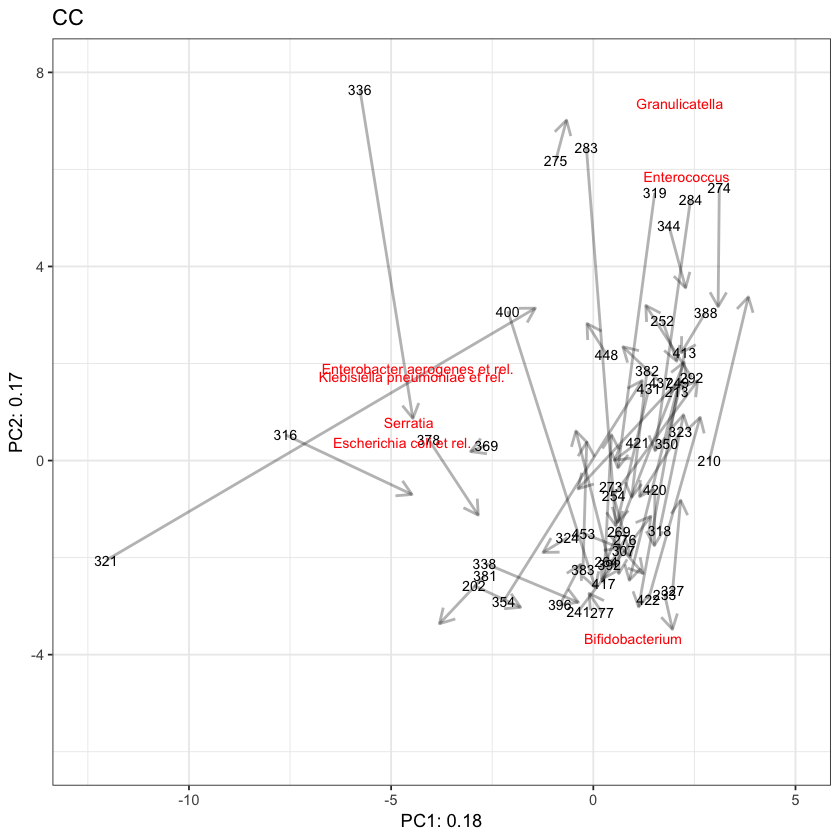

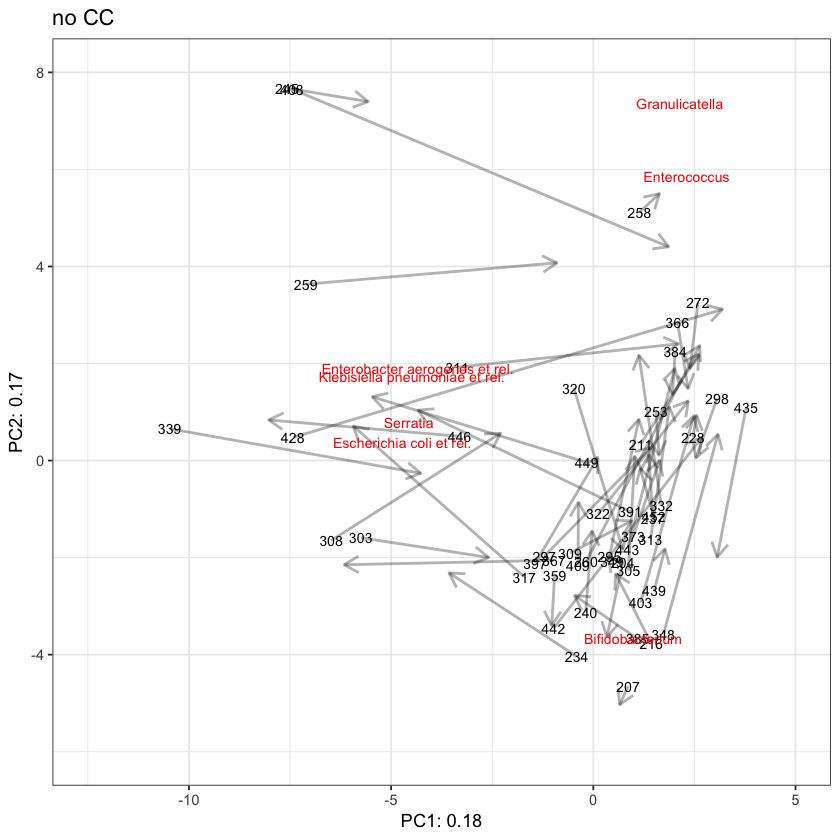

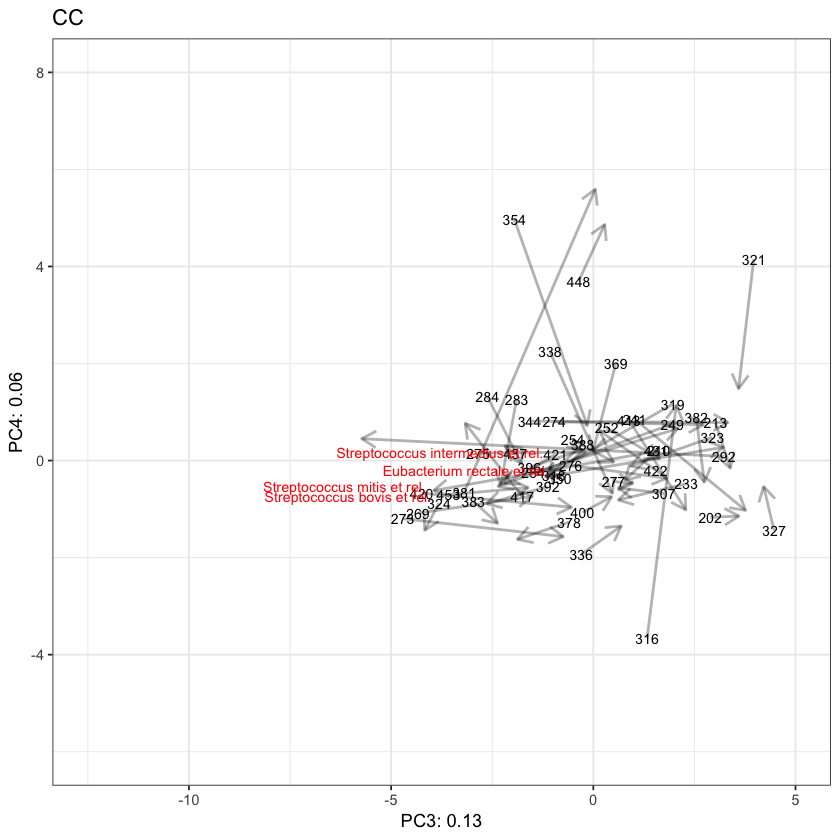

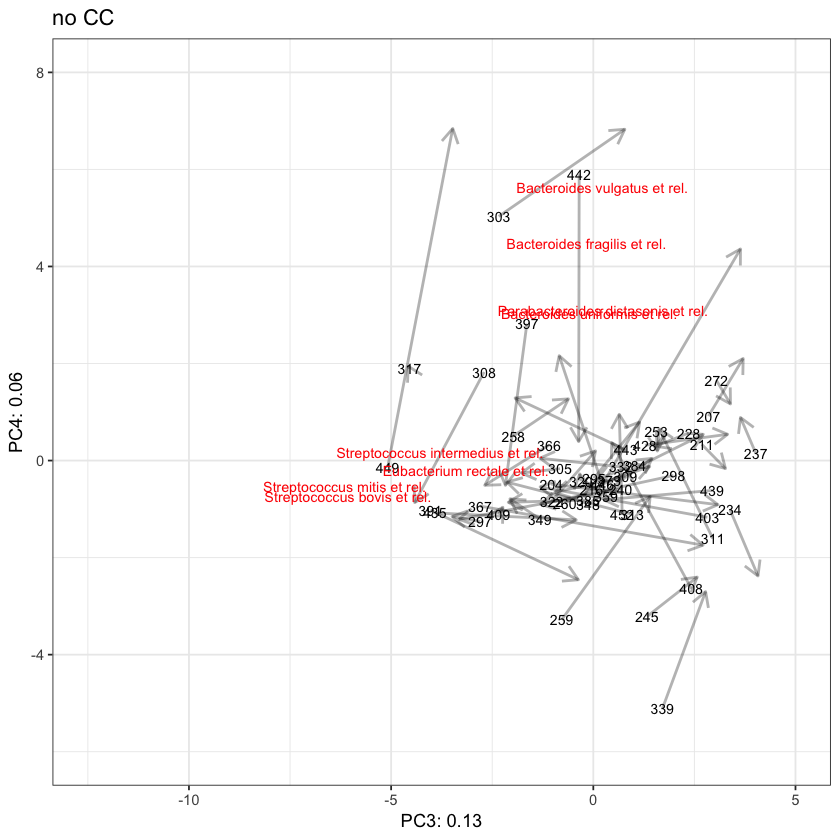

In [17]:
# PC1 and PC2
data %>%
    filter(cc == "yes") %>%
    arrange(time) %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC1, PC2, label = ifelse(abs(PC1) > 2.5 | abs(PC2) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    ggtitle("CC") +
    theme_bw()
data %>%
    filter(cc == "no") %>%
    arrange(time) %>%
    ggplot(aes(PC1, PC2, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC1, PC2, label = ifelse(abs(PC1) > 2.5 | abs(PC2) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC1: ", pc1, sep="")) +  ylab(paste("PC2: ", pc2, sep="")) +
    ggtitle("no CC") +
    theme_bw()

# PC3 and PC4
data %>%
    filter(cc == "yes") %>%
    arrange(time) %>%
    ggplot(aes(PC3, PC4, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC3, PC4, label = ifelse(abs(PC3) > 2.5 | abs(PC3) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC3: ", pc3, sep="")) +  ylab(paste("PC4: ", pc4, sep="")) +
    ggtitle("CC") +
    theme_bw()
data %>%
    filter(cc == "no") %>%
    arrange(time) %>%
    ggplot(aes(PC3, PC4, label = subject_id)) +
    geom_path(aes(group = as.factor(subject_id)), arrow = arrow(length = unit(0.35,"cm"), ends = "last"), alpha = 0.3, size = 0.8) +
    scale_color_manual(values = c("red", "blue")) +
    geom_text(size = 3, aes(label = ifelse(time == "pre", subject_id, ""))) +
    geom_text(
        size = 3,
        data = pcx_rot,
        aes(PC3, PC4, label = ifelse(abs(PC3) > 2.5 | abs(PC4) > 2.5, genus, "")), 
            color = "red") +
    xlim(-12.5, 5) + ylim(-6, 8) +
    xlab(paste("PC3: ", pc3, sep="")) +  ylab(paste("PC4: ", pc4, sep="")) +
    ggtitle("no CC") +
    theme_bw()

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance, which then is the Aitchison distance. I

In [18]:
# how many NA? --> 4 CC and 1 no CC
# sd_to_df(pseq.rel) %>% filter(is.na(bf_count_s))
# complete cases for meta data and otus:
meta.rel <- sd_to_df(pseq.rel) %>% na.omit()
otus.rel <- otu_to_df(pseq.rel, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.rel$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.rel)
anova(betadisper(dist, meta.rel$cc))
anova(betadisper(dist, meta.rel$time))
anova(betadisper(dist, meta.rel$groups))
pm <- adonis(otus.rel ~ time * cc + age_d_s + bf_count_s + sibling + childsex, method = "bray", data = meta.rel)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq      Mean Sq     F value   Pr(>F)   
Groups      1 0.007803774 0.007803774 0.1904743 0.6630571
Residuals 176 7.210760057 0.040970228        NA        NA

Df  Sum Sq     Mean Sq    F value  Pr(>F)   
Groups      1 0.07225192 0.07225192 1.779537 0.1839298
Residuals 176 7.14586776 0.04060152       NA        NA

Df  Sum Sq    Mean Sq    F value  Pr(>F)   
Groups      3 0.1504628 0.05015427 1.250064 0.2932137
Residuals 174 6.9811151 0.04012135       NA        NA

In [20]:
pm$aov.tab

Df  SumsOfSqs   MeanSqs    F.Model   R2          Pr(>F)
time         1  0.16843436 0.16843436 1.3980377 0.007669900 0.215 
cc           1  0.09353884 0.09353884 0.7763904 0.004259425 0.565 
age_d_s      1  0.28685127 0.28685127 2.3809209 0.013062184 0.053 
bf_count_s   1  0.31583275 0.31583275 2.6214728 0.014381898 0.022 
sibling      1  0.23330287 0.23330287 1.9364588 0.010623781 0.095 
childsex     1  0.26590719 0.26590719 2.2070810 0.012108466 0.059 
time:cc      1  0.11511778 0.11511778 0.9554998 0.005242053 0.428 
Residuals  170 20.48145145 0.12047913        NA 0.932652292    NA 
Total      177 21.96043650         NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


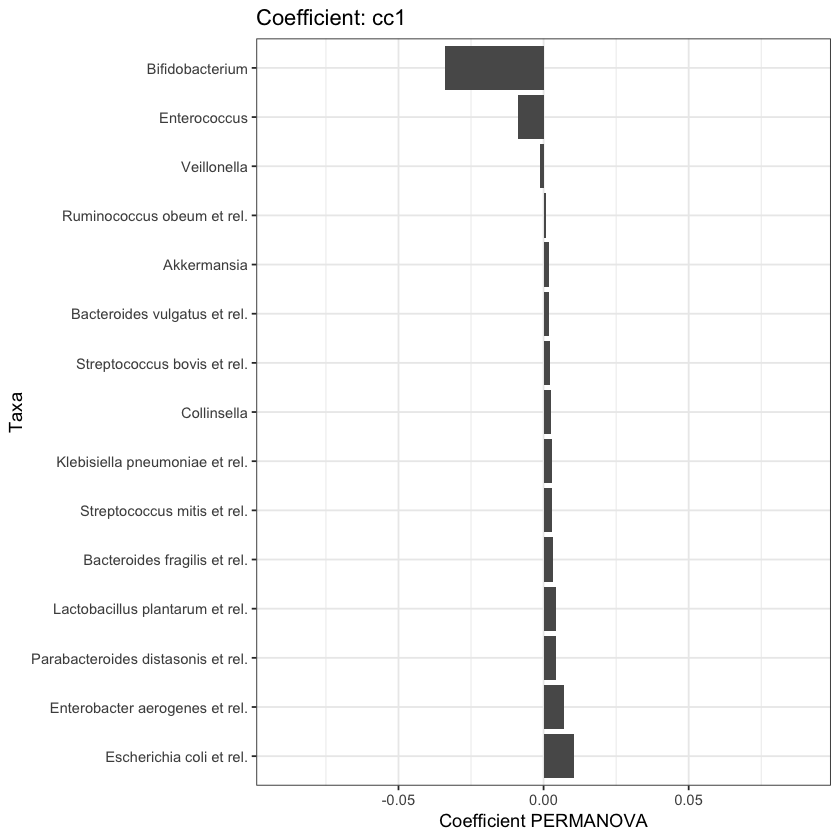

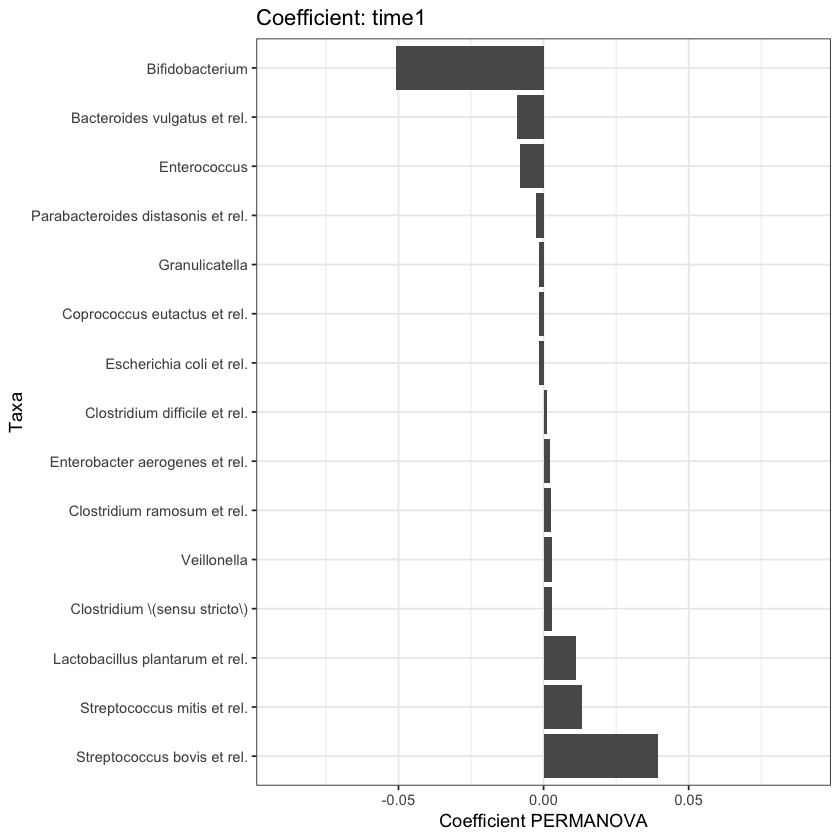

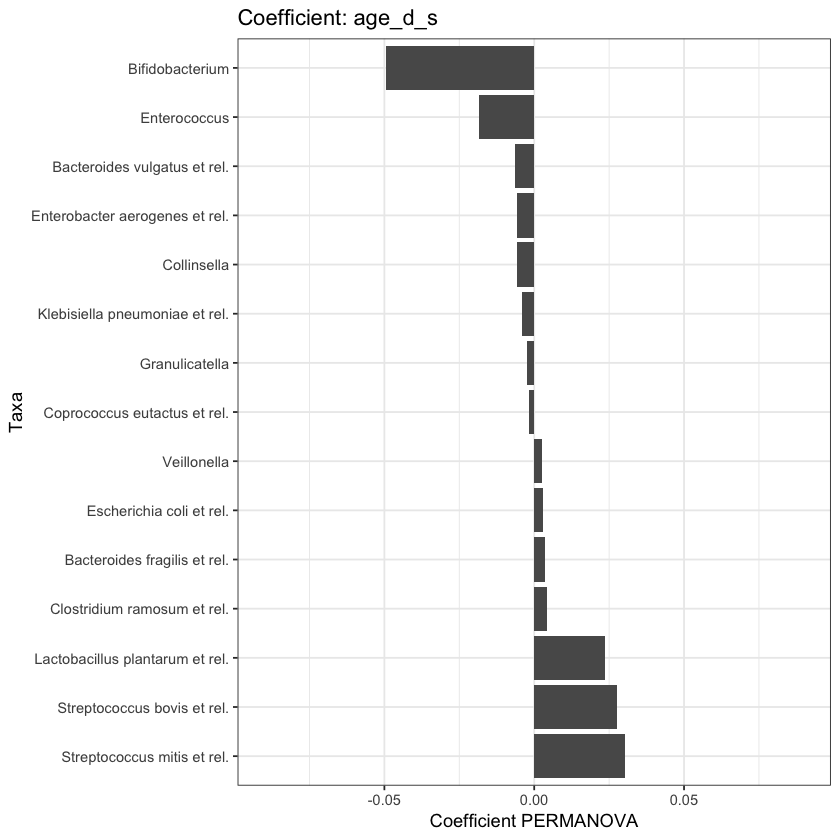

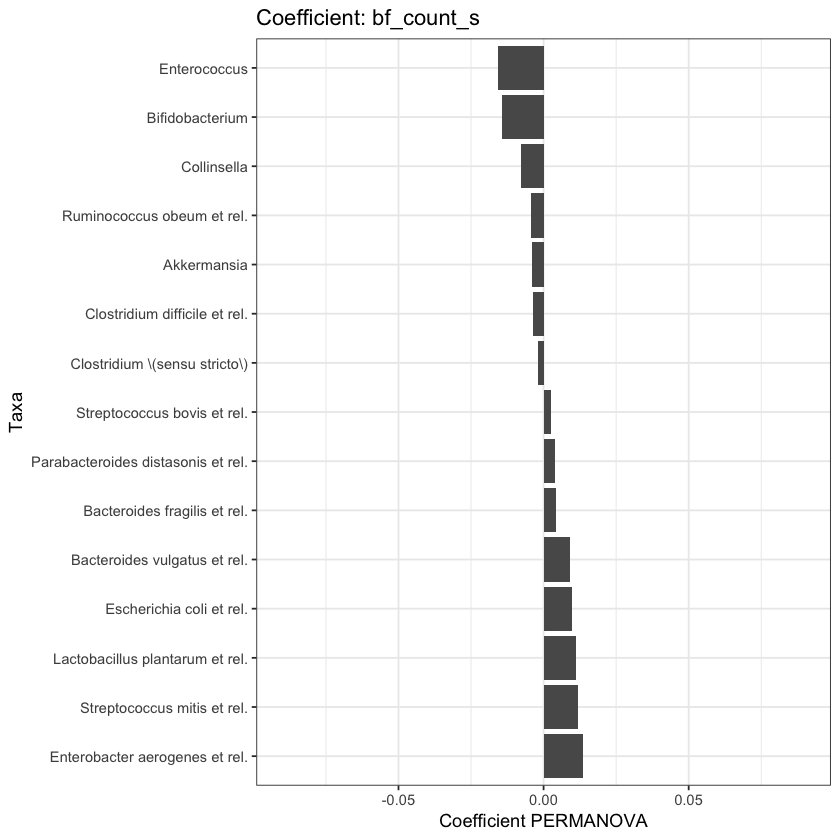

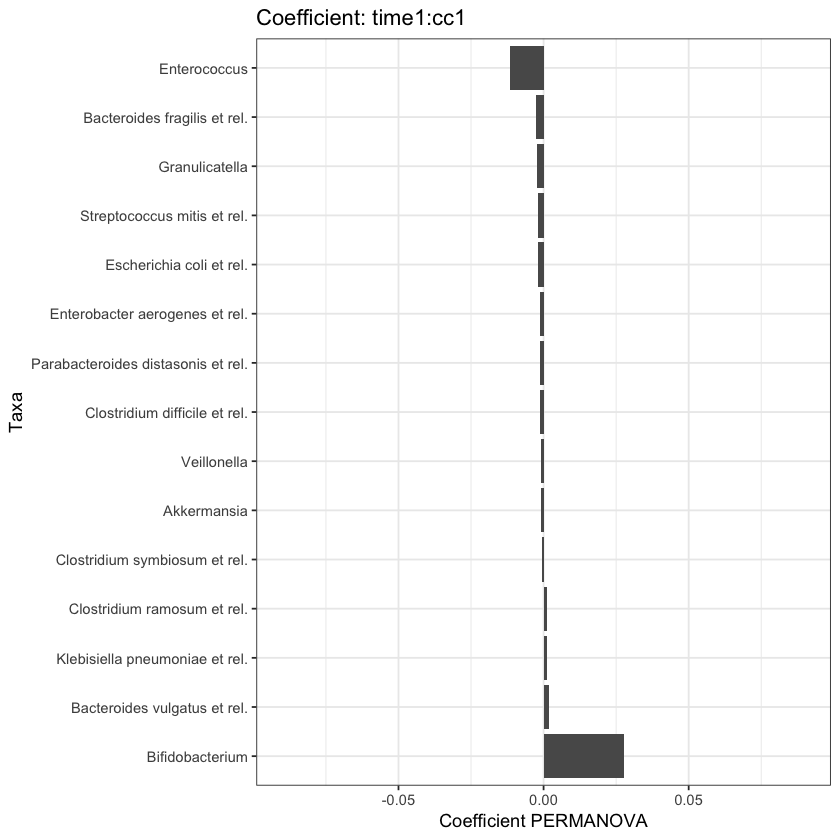

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


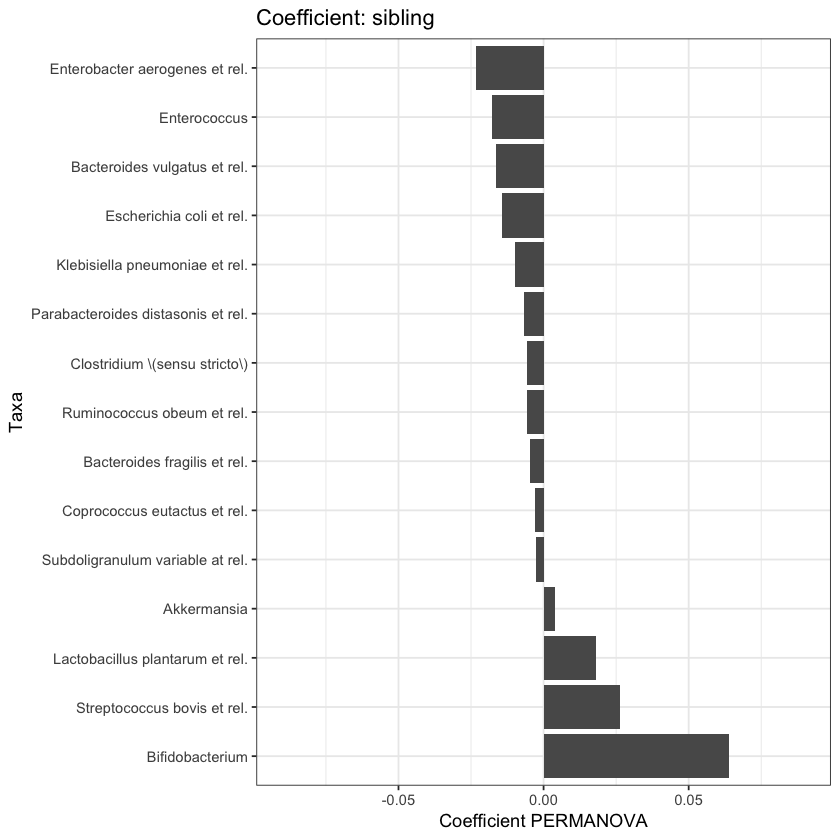

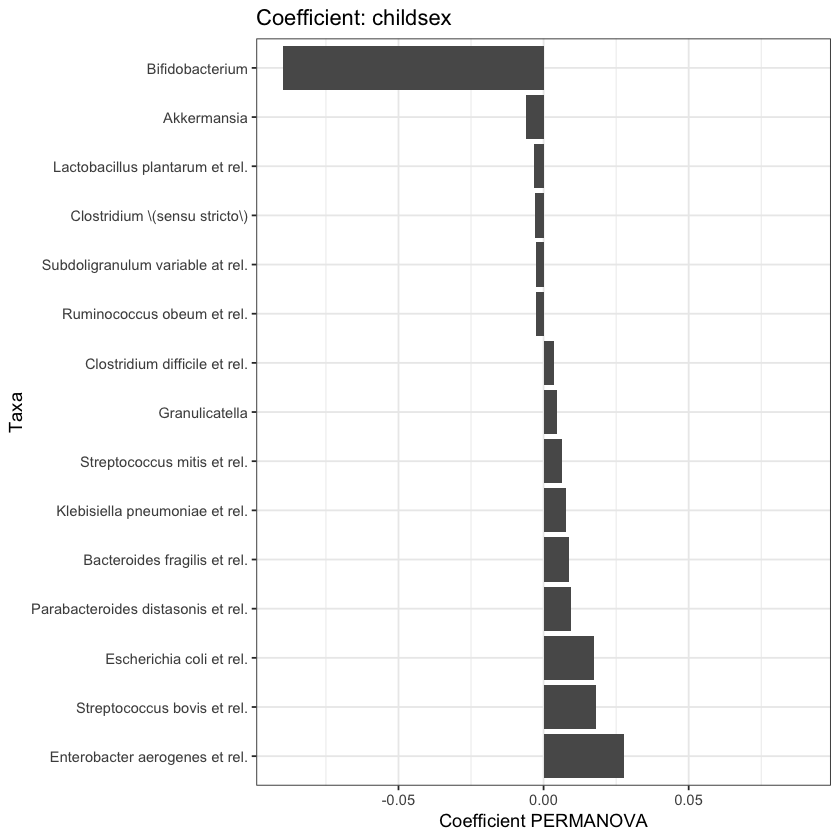

In [21]:
coef_v <- c("cc1", "time1", "age_d_s", "bf_count_s", "time1:cc1", "sibling", "childsex")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.09, 0.09) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_rel_ab.png")))
    p
})
pmps

In [22]:
# clr/euclidean
meta.clr <- sd_to_df(pseq.clr) %>% na.omit()
otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.clr$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.clr, method = "euclidean")
anova(betadisper(dist, meta.clr$cc))
anova(betadisper(dist, meta.clr$time))
anova(betadisper(dist, meta.clr$groups))
pm <- adonis(otus.clr ~ time * cc + age_d_s + bf_count_s + sibling + childsex, method = "euclidean", data = meta.clr)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Df  Sum Sq     Mean Sq   F value  Pr(>F)   
Groups      1   13.78987 13.789866 2.317946 0.1296835
Residuals 176 1047.05477  5.949175       NA        NA

Df  Sum Sq     Mean Sq   F value  Pr(>F)   
Groups      1   11.88842 11.888416 1.993301 0.1597617
Residuals 176 1049.69664  5.964185       NA        NA

Df  Sum Sq     Mean Sq  F value  Pr(>F)  
Groups      3   29.91234 9.970781 1.650578 0.179531
Residuals 174 1051.09593 6.040781       NA       NA

In [23]:
pm$aov.tab

Df  SumsOfSqs  MeanSqs   F.Model   R2          Pr(>F)
time         1   52.61316  52.61316 1.3123638 0.007113162 0.184 
cc           1   47.49937  47.49937 1.1848072 0.006421791 0.269 
age_d_s      1   73.56149  73.56149 1.8348915 0.009945323 0.043 
bf_count_s   1  211.38022 211.38022 5.2725926 0.028578057 0.001 
sibling      1  102.37401 102.37401 2.5535808 0.013840701 0.005 
childsex     1   60.40861  60.40861 1.5068107 0.008167087 0.089 
time:cc      1   33.39090  33.39090 0.8328906 0.004514362 0.600 
Residuals  170 6815.36397  40.09038        NA 0.921419516    NA 
Total      177 7396.59172        NA        NA 1.000000000    NA

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


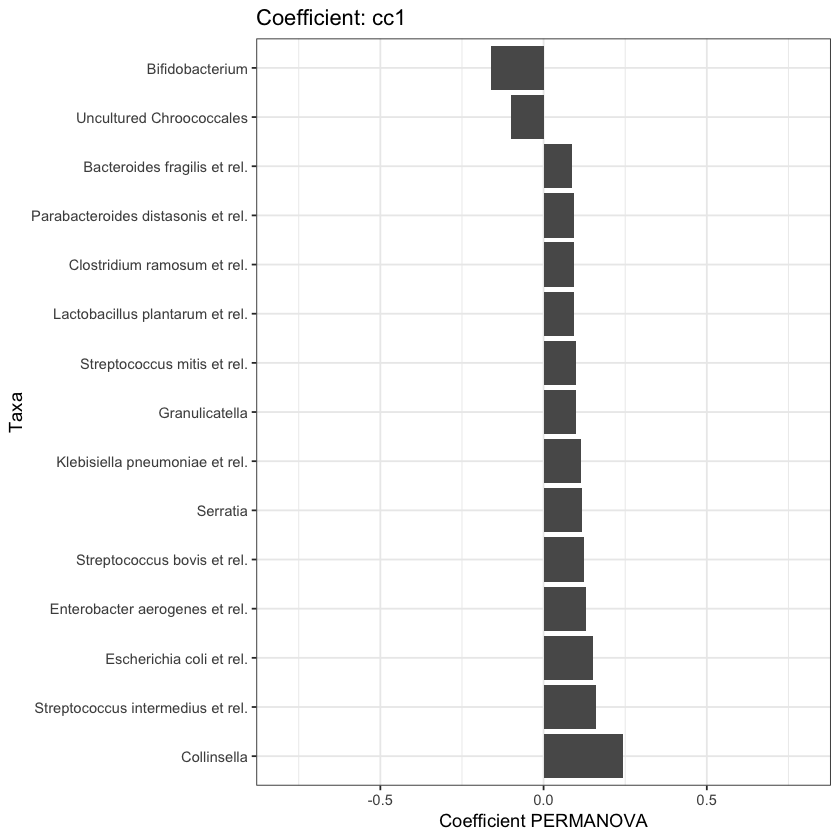

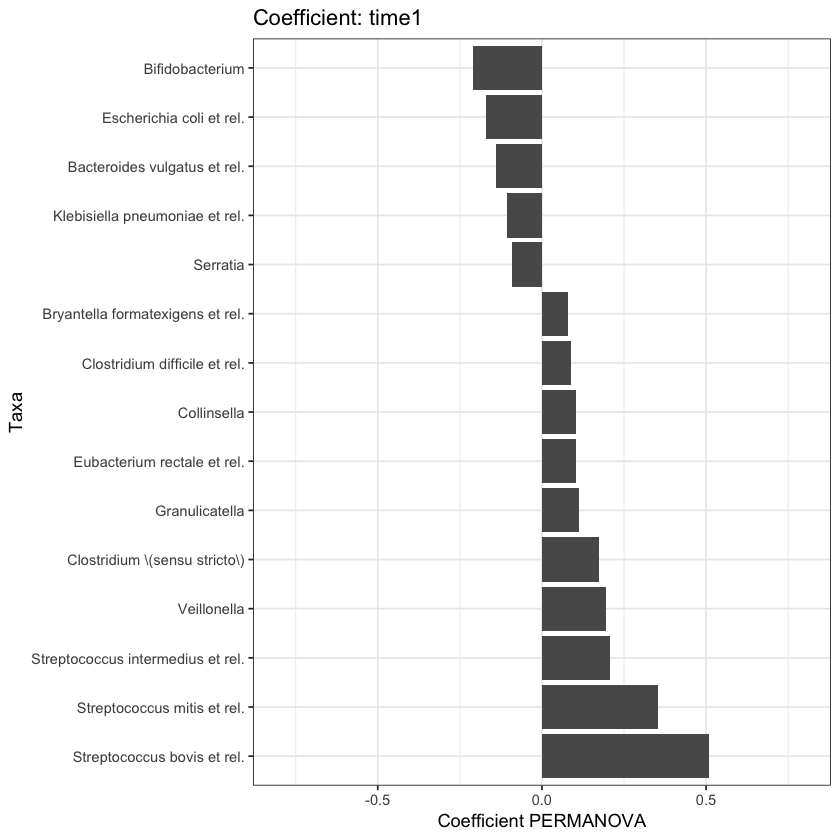

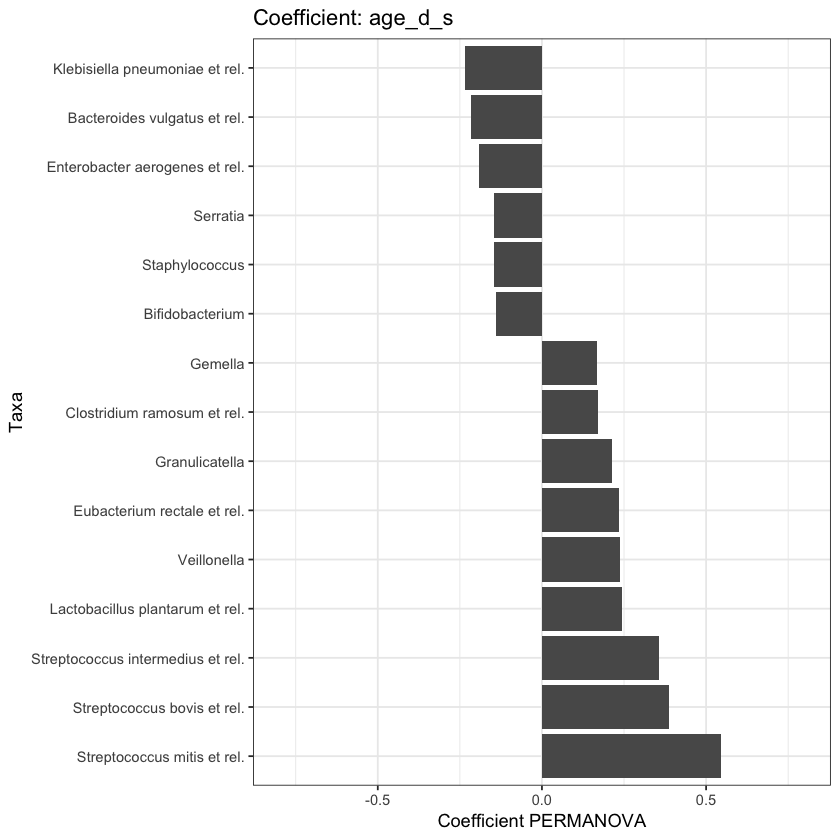

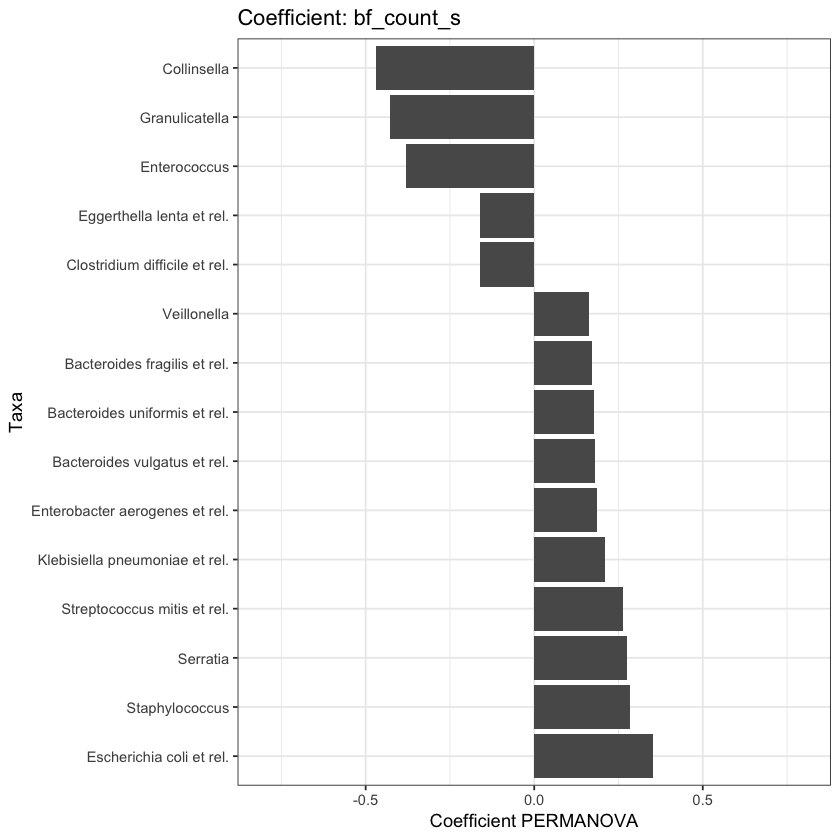

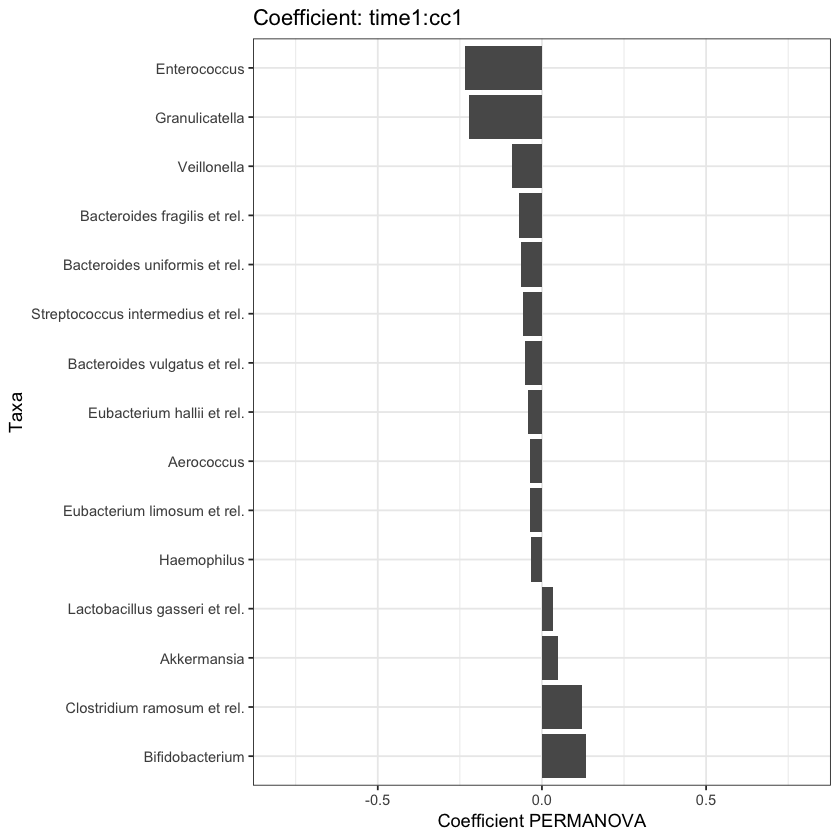

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


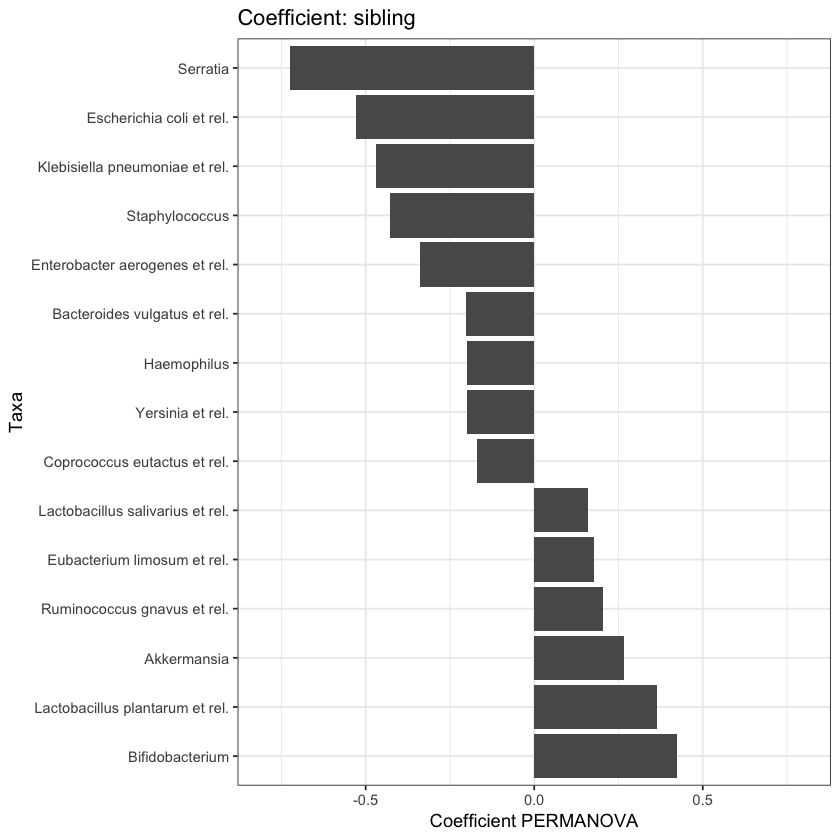

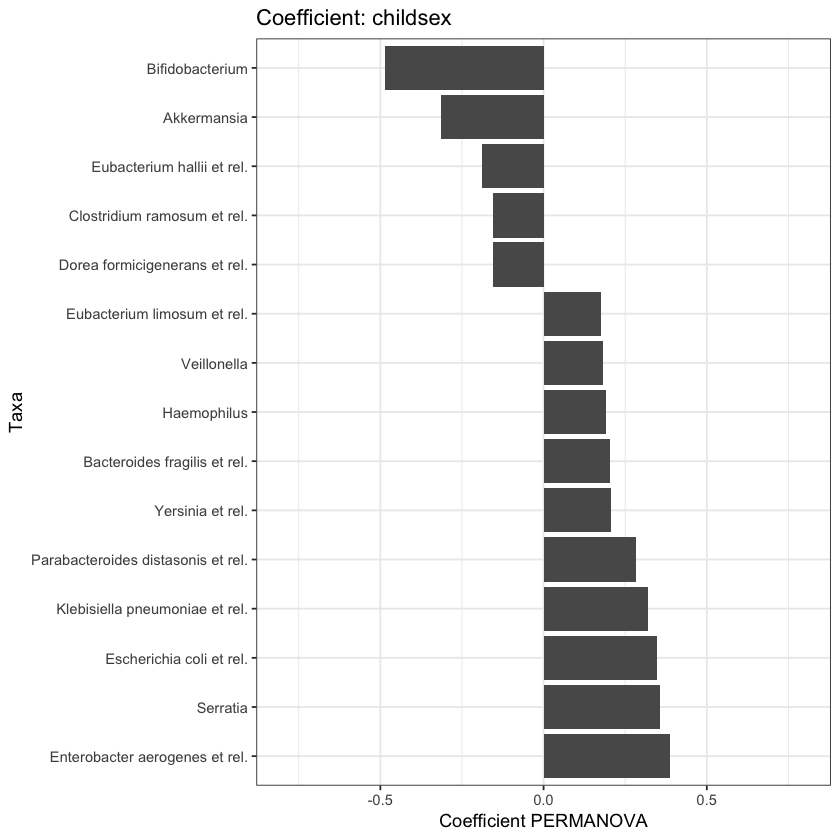

In [24]:
coef_v <- c("cc1", "time1", "age_d_s", "bf_count_s", "time1:cc1", "sibling", "childsex")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.8, 0.8) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_clr.png")))
    p
})
pmps

In [25]:
### make tables for permanovs apa
pm_table <- rownames_to_column(pm$aov.tab, "Model Parameters")
pm_table <- 
  mutate_if(pm_table, is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`)) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)
colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )

In [26]:
pm_table

Model Parameter Sum of Squares Mean Sum of Squares F     Df  p     R Square
1 time              52.613       52.613              1.312   1 0.184 0.007   
2 cc                47.499       47.499              1.185   1 0.269 0.006   
3 age_d_s           73.561       73.561              1.835   1 0.043 0.010   
4 bf_count_s       211.380       211.38              5.273   1 0.001 0.029   
5 sibling          102.374       102.374             2.554   1 0.005 0.014   
6 childsex          60.409       60.409              1.507   1 0.089 0.008   
7 time:cc           33.391       33.391              0.833   1 0.6   0.005   
8 Residuals       6815.364       40.09               -     170 -     0.921   
9 Total           7396.592       -                   -     177 -     1.000

# Principal Coordinate Analysis

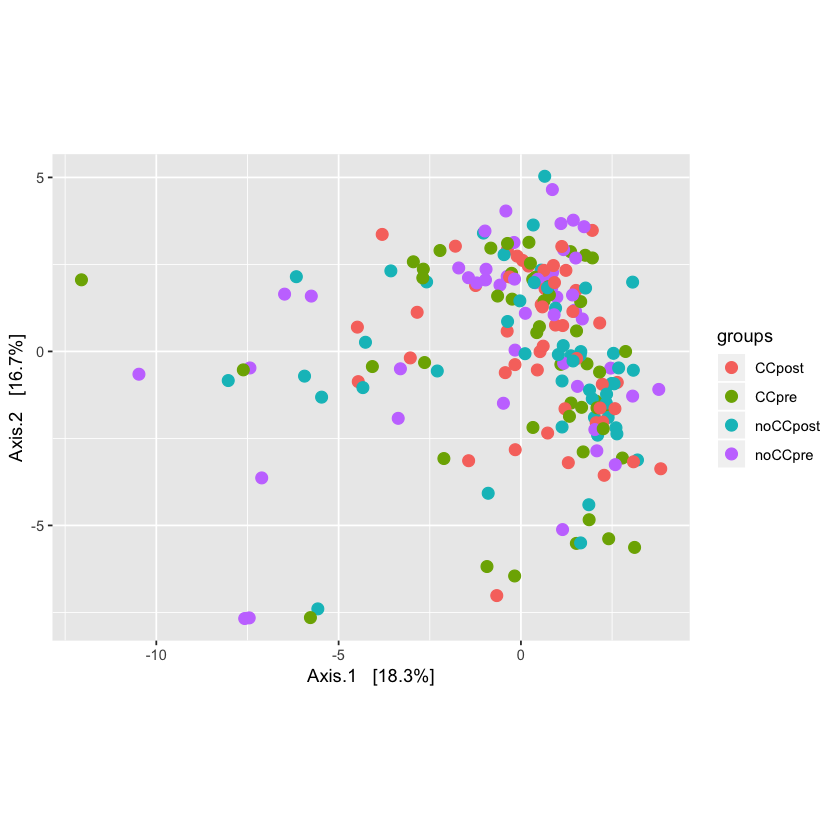

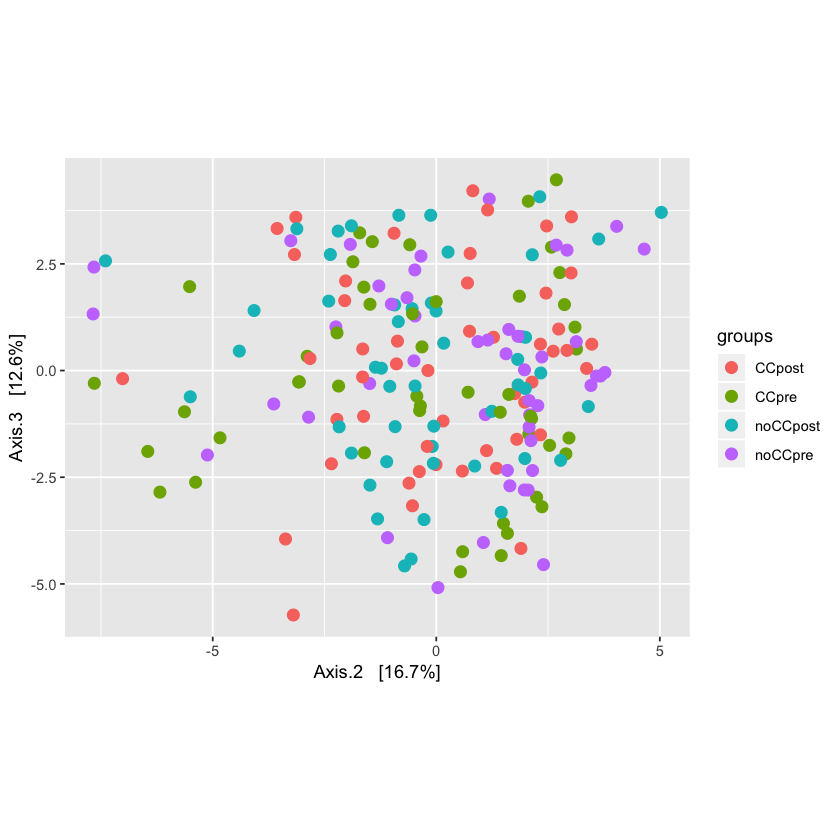

In [21]:
# # PCoA bray, can we differentiate the post CC from all other infants?
# cc_pcoa <- ordinate(pseq.rel, method = "PCoA", distance = "bray")
# e_values <- cc_pcoa$values$Eigenvalues
# plot_ordination(pseq.rel, cc_pcoa, color = "groups") +
#     geom_point(size = 3) +
#     coord_fixed(sqrt(e_values[2] / e_values[1])) 
# # axes 2:3
# plot_ordination(pseq.rel, cc_pcoa, color = "groups", axes = 2:3) +
#     geom_point(size = 3) +
#     coord_fixed(sqrt(e_values[2] / e_values[1])) 


# PCoA Aitchison, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.clr, method = "PCoA", distance = "euclidean")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.clr, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.clr, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

# Hierarchical Generalized Linear Models

In [22]:
future::availableCores()

system 
     8

In [23]:
library(brms)
library(broom)
library(parallel)
options(mc.cores = 6)

Loading required package: Rcpp
Loading 'brms' package (version 2.6.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:affy’:

    mm

The following object is masked from ‘package:phyloseq’:

    nsamples



## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

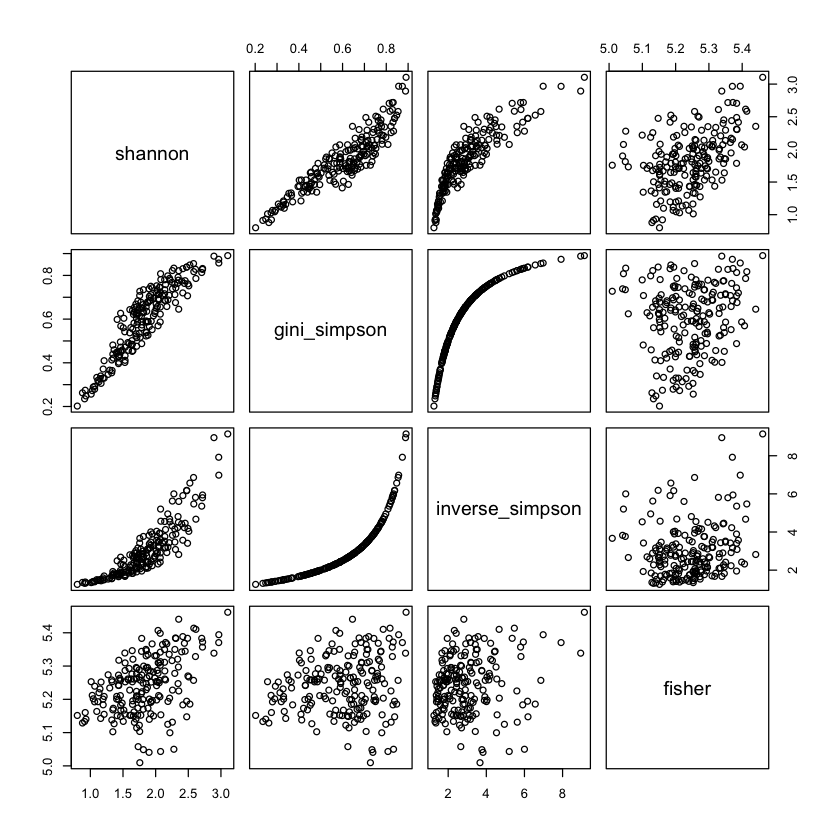

shannon   gini_simpson inverse_simpson fisher   
shannon         1.0000000 0.9164824    0.8751893       0.4663433
gini_simpson    0.9164824 1.0000000    0.8733145       0.1690166
inverse_simpson 0.8751893 0.8733145    1.0000000       0.1793253
fisher          0.4663433 0.1690166    0.1793253       1.0000000

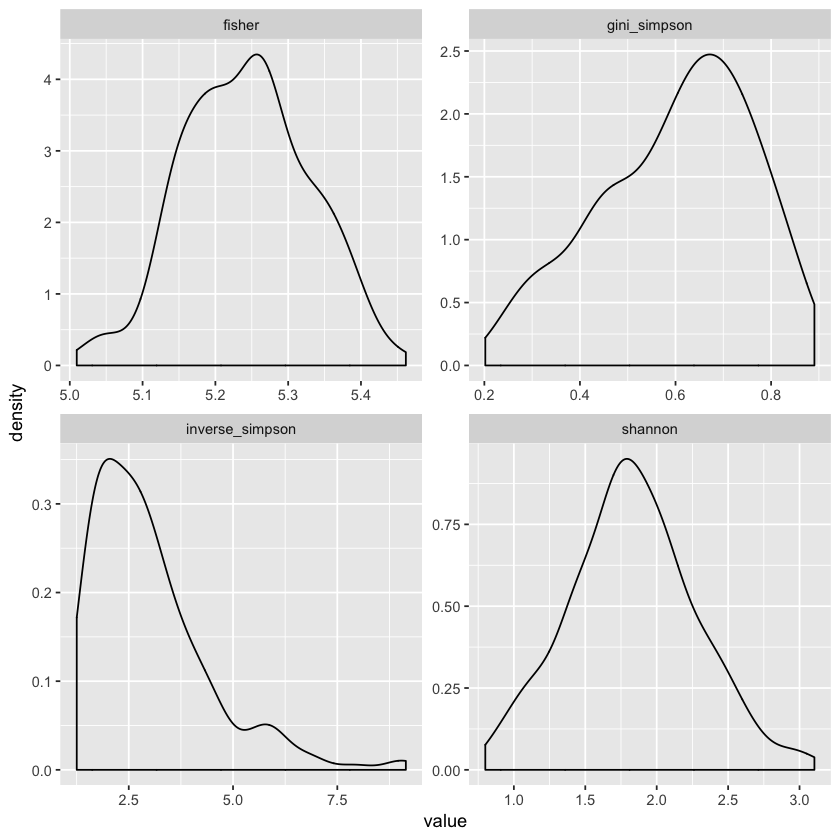

In [24]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [25]:
dir.create(here("models/final_analyses"))
folder <- here("models/final_analyses")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson", "fisher")

Warning message in dir.create(here("models/final_analyses")):
“'/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/final_analyses' already exists”

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [26]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [27]:
prior <- 
    c(
        set_prior("normal(0, 2)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )

brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [28]:
# gaussian family and listwise deletion
div_models <- lapply(diversity_index, brm_div)

In [29]:
# gaussian and mi for bf_count_s missingness
div_models_mi <- lapply(diversity_index, brm_div_mi)

In [30]:
# skew family and listwise deletion
div_models_skew <- lapply(diversity_index, brm_div_skew)

In [31]:
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- lapply(diversity_index, brm_div_skew_mi)

In [32]:
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [33]:
lapply(div_models_mi, function(x) {
    tidy(x)[1:13,]
})

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.89372706 0.08760532  1.753445984
2              b_bfcounts_Intercept  0.46234939 0.29386602 -0.015742227
3                   b_shannon_ccyes  0.02370585 0.09160557 -0.125224778
4                b_shannon_timepost -0.03032074 0.11223950 -0.211971957
5                 b_shannon_age_d_s  0.09488080 0.06176213 -0.006307064
6          b_shannon_ccyes:timepost -0.24639353 0.09381100 -0.400108162
7                  b_bfcounts_ccyes -0.03407822 0.19982350 -0.362423937
8               b_bfcounts_timepost -0.43910298 0.24045711 -0.831404010
9                b_bfcounts_shannon -0.13601546 0.12722321 -0.353022236
10               b_bfcounts_age_d_s -0.14331386 0.15061123 -0.392863281
11        b_bfcounts_ccyes:timepost  0.11835183 0.12698171 -0.093159905
12         bsp_shannon_mibf_count_s -0.07295101 0.03820602 -0.133894329
13 sd_subject_id__shannon_Intercept  0.26541893 0.04321883  0.192727029
          upper
1   2.037094811
2   0.943000411
3   0.171806143
4   0.153263707
5   0.196059967
6  -0.093027107
7   0.290132736
8  -0.042495427
9   0.067359881
10  0.097669637
11  0.326718760
12 -0.008321062
13  0.334479016

[[2]]
                                      term    estimate  std.error        lower
1               b_inversesimpson_Intercept  3.22569051 0.26070535  2.800951843
2                     b_bfcounts_Intercept  0.25419873 0.22339483 -0.106420185
3                   b_inversesimpson_ccyes  0.13468297 0.29144216 -0.342019559
4                b_inversesimpson_timepost -0.20417323 0.37400578 -0.816580885
5                 b_inversesimpson_age_d_s  0.32228711 0.17212246  0.041340731
6          b_inversesimpson_ccyes:timepost -0.75851277 0.38619160 -1.384214519
7                         b_bfcounts_ccyes -0.04469366 0.19992652 -0.381508917
8                      b_bfcounts_timepost -0.47929547 0.23013498 -0.863909877
9               b_bfcounts_inverse_simpson -0.01083126 0.03846016 -0.074336714
10                      b_bfcounts_age_d_s -0.12583155 0.14714968 -0.368492877
11               b_bfcounts_ccyes:timepost  0.15063834 0.12698477 -0.062067829
12         bsp_inversesimpson_mibf_count_s -0.13461956 0.11763954 -0.327359186
13 sd_subject_id__inversesimpson_Intercept  0.14195630 0.16876613  0.005596575
         upper
1   3.66170288
2   0.62681201
3   0.61395228
4   0.40479974
5   0.60788740
6  -0.10784776
7   0.28154172
8  -0.10893515
9   0.05152277
10  0.11563695
11  0.35262806
12  0.05923653
13  0.55019319

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.632562709 0.03363762  0.577647724
2                  b_bfcounts_Intercept  0.255714710 0.26844599 -0.189677044
3                   b_ginisimpson_ccyes  0.002755617 0.03628283 -0.056300891
4                b_ginisimpson_timepost -0.025604929 0.04377892 -0.096520875
5                 b_ginisimpson_age_d_s  0.044671334 0.02292286  0.006573206
6          b_ginisimpson_ccyes:timepost -0.086298474 0.03776556 -0.149878569
7                      b_bfcounts_ccyes -0.053484388 0.19976960 -0.384633111
8                   b_bfcounts_timepost -0.515652166 0.23456374 -0.891399649
9               b_bfcounts_gini_simpson -0.020617814 0.30809875 -0.529861910
10                   b_bfcounts_age_d_s -0.102261832 0.14850855 -0.352699703
11            b_bfcounts_ccyes:timepost  0.158869057 0.12880710 -0.050693480
12         bsp_ginisimpson_mibf_count_s -0.006784738 0.01416000 -0.030120438
13 sd_subject_id__ginisimpson_Intercept  0.094402430 0.01949762  0.062399541
         upper
1   0.68792285
2   0.70183659
3   0.06334454
4   0.04706110
5   0.08265053
6  -0.02423238
7   0.27393656
8  -0.12668582
9   0.47250104
10  0.14235810
11  0.37128422
12  0.01625591
13  0.12412522

[[4]]
                              term      estimate   std.error       lower
1               b_fisher_Intercept  5.2278223560 0.018066174  5.

In [34]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})
#lapply(div_models_skew_mi, plot)

[[1]]
                               term    estimate  std.error        lower
1               b_shannon_Intercept  1.88439961 0.08948574  1.733681580
2              b_bfcounts_Intercept  0.45135456 0.27270598  0.005144036
3                   b_shannon_ccyes  0.04833789 0.09769097 -0.112292605
4                b_shannon_timepost -0.03032499 0.11477478 -0.218164353
5                 b_shannon_age_d_s  0.09938759 0.06182313 -0.002107777
6          b_shannon_ccyes:timepost -0.26439782 0.09542340 -0.423324577
7                  b_bfcounts_ccyes -0.01936861 0.18564966 -0.323159946
8               b_bfcounts_timepost -0.37378396 0.21556695 -0.732124668
9                b_bfcounts_shannon -0.15262150 0.12165606 -0.357031937
10               b_bfcounts_age_d_s -0.15062888 0.13667574 -0.376072936
11        b_bfcounts_ccyes:timepost  0.09603023 0.12006110 -0.106110687
12         bsp_shannon_mibf_count_s -0.07389353 0.03860975 -0.135863883
13 sd_subject_id__shannon_Intercept  0.28417321 0.04850299  0.209750750
         upper
1   2.03161369
2   0.90418466
3   0.20676035
4   0.15692999
5   0.20223886
6  -0.10367155
7   0.28671921
8  -0.01618459
9   0.04574673
10  0.07560964
11  0.29680609
12 -0.01085610
13  0.35764147

[[2]]
                                      term     estimate  std.error       lower
1               b_inversesimpson_Intercept  3.226386996 0.17351370  2.94757889
2                     b_bfcounts_Intercept  0.202923677 0.21925428 -0.15924557
3                   b_inversesimpson_ccyes -0.114011137 0.17752844 -0.40417514
4                b_inversesimpson_timepost -0.068346923 0.21876420 -0.43471717
5                 b_inversesimpson_age_d_s  0.148743926 0.11209886 -0.02787599
6          b_inversesimpson_ccyes:timepost -0.261933840 0.23317444 -0.65113197
7                         b_bfcounts_ccyes -0.029725745 0.19246100 -0.34968131
8                      b_bfcounts_timepost -0.424796930 0.23122331 -0.80836883
9               b_bfcounts_inverse_simpson -0.005609759 0.03620502 -0.06608942
10                      b_bfcounts_age_d_s -0.120285592 0.14793128 -0.35714836
11               b_bfcounts_ccyes:timepost  0.122243060 0.12321355 -0.08417011
12         bsp_inversesimpson_mibf_count_s -0.054792519 0.06305977 -0.15641730
13 sd_subject_id__inversesimpson_Intercept  0.067325228 0.05888357  0.00455316
         upper
1   3.51501284
2   0.56225791
3   0.18298239
4   0.27486104
5   0.33867752
6   0.11412895
7   0.28461194
8  -0.04877715
9   0.05316490
10  0.12286306
11  0.32292940
12  0.04990787
13  0.18346060

[[3]]
                                   term     estimate  std.error        lower
1               b_ginisimpson_Intercept  0.626203128 0.03059580  0.575732125
2                  b_bfcounts_Intercept  0.201030153 0.26775310 -0.233855789
3                   b_ginisimpson_ccyes  0.015701699 0.03350009 -0.040026203
4                b_ginisimpson_timepost -0.026751817 0.03950818 -0.091274767
5                 b_ginisimpson_age_d_s  0.041533162 0.02064305  0.008825657
6          b_ginisimpson_ccyes:timepost -0.084734768 0.03465564 -0.142713890
7                      b_bfcounts_ccyes -0.039831353 0.19463838 -0.362587079
8                   b_bfcounts_timepost -0.434513718 0.22913305 -0.801177797
9               b_bfcounts_gini_simpson -0.005447869 0.29295612 -0.487518703
10                   b_bfcounts_age_d_s -0.113902207 0.14534421 -0.354815946
11            b_bfcounts_ccyes:timepost  0.127890349 0.12143100 -0.071717118
12         bsp_ginisimpson_mibf_count_s -0.004403476 0.01275915 -0.024702015
13 sd_subject_id__ginisimpson_Intercept  0.084716058 0.01995183  0.052409802
         upper
1   0.67607847
2   0.63824190
3   0.07021493
4   0.03834124
5   0.07732153
6  -0.02789801
7   0.28669738
8  -0.05944830
9   0.47934601
10  0.11934161
11  0.32444190
12  0.01665235
13  0.11572115

[[4]]
                              term     estimate   std.error       lower
1               b_fisher_Intercept  5.227132452 0.017768802  5.19777394
2      

In [35]:
tidy(div_models_skew[[1]]) %>% filter (term == "alpha")

term  estimate  std.error lower     upper   
1 alpha -1.971749 2.543389  -6.510013 1.694973

In [36]:
#posterior_samples(div_models_skew_mi) %>% colnames()

In [37]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost")) %>%
        rename(
            noccpre = glue("b_{var_name}_Intercept"), 
            ccpre = glue("b_{var_name}_ccyes"),
            noccpost = glue("b_{var_name}_timepost"),
            ccpost = glue("b_{var_name}_ccyes:timepost")) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}


In [38]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre
        ) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, noccpost_ccpre) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
})


[[1]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff  lower   upper  prob
  <chr>                <dbl>  <dbl>   <dbl> <dbl>
1 ccpost_ccpre       -0.277  -0.499 -0.0444 0.990
2 ccpost_noccpost    -0.223  -0.406 -0.0424 0.990
3 ccpost_noccpre     -0.253  -0.561  0.0400 0.950
4 ccpre_noccpre       0.0237 -0.151  0.208  0.390
5 noccpost_ccpre     -0.0540 -0.240  0.166  0.702
6 noccpost_noccpre   -0.0303 -0.247  0.196  0.604

[[2]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff  lower   upper  prob
  <chr>                <dbl>  <dbl>   <dbl> <dbl>
1 ccpost_ccpre        -0.963 -1.71  -0.210  0.994
2 ccpost_noccpost     -0.624 -1.21  -0.0207 0.979
3 ccpost_noccpre      -0.828 -1.70   0.0706 0.966
4 ccpre_noccpre        0.135 -0.435  0.726  0.322
5 noccpost_ccpre      -0.339 -0.960  0.352  0.843
6 noccpost_noccpre    -0.204 -0.906  0.552  0.711

[[3]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff   lower   upper  prob
  <chr>                <dbl>   <dbl>   <dbl> <dbl>
1 ccpost_ccpre      -0.112   -0.197  -0.0304 0.995
2 ccpost_noccpost   -0.0835  -0.151  -0.0154 0.991
3 ccpost_noccpre    -0.109   -0.213   0.0163 0.970
4 ccpre_noccpre      0.00276 -0.0692  0.0717 0.474
5 noccpost_ccpre    -0.0284  -0.104   0.0491 0.768
6 noccpost_noccpre  -0.0256  -0.113   0.0596 0.720

[[4]]
# A tibble: 6 x 5
# Groups:   comparison [6]
  comparison       mean_diff   lower  upper  prob
  <chr>                <dbl>   <dbl>  <dbl> <dbl>
1 ccpost_ccpre       0.00790 -0.0378 0.0514 0.371
2 ccpost_noccpost   -0.00556 -0.0422 0.0303 0.617
3 ccpost_noccpre     0.0215  -0.0399 0.0835 0.251
4 ccpre_noccpre      0.0135  -0.0222 0.0486 0.234
5 noccpost_ccpre     0.0135  -0.0275 0.0559 0.266
6 noccpost_noccpre   0.0270  -0.0190 0.0704 0.121

In [39]:
data %>% select(groups, shannon, inverse_simpson, gini_simpson, fisher) %>%
    gather(index, value, -groups) %>%
    group_by(groups, index) %>%
    summarise(mean = mean(value), meadian = median(value), sd = sd(value))

groups   index           mean      meadian   sd        
1  CCpost   fisher          5.2522786 5.2528107 0.07784588
2  CCpost   gini_simpson    0.5746876 0.6293380 0.16915477
3  CCpost   inverse_simpson 2.7684013 2.6978756 1.24517668
4  CCpost   shannon         1.7645493 1.8542119 0.44695679
5  CCpre    fisher          5.2368965 5.2276967 0.07783146
6  CCpre    gini_simpson    0.6152299 0.6556872 0.17641426
7  CCpre    inverse_simpson 3.1935644 2.9043359 1.44705569
8  CCpre    shannon         1.8606652 1.9031907 0.49455085
9  noCCpost fisher          5.2587590 5.2534083 0.09206145
10 noCCpost gini_simpson    0.6277778 0.6326045 0.14194491
11 noCCpost inverse_simpson 3.2110094 2.7218627 1.64709775
12 noCCpost shannon         1.9287132 1.8741298 0.43620719
13 noCCpre  fisher          5.2220530 5.2488865 0.09309052
14 noCCpre  gini_simpson    0.5830407 0.5684299 0.15096151
15 noCCpre  inverse_simpson 2.8362804 2.3171205 1.36552083
16 noCCpre  shannon         1.7688315 1.7115858 0.37997983

Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image


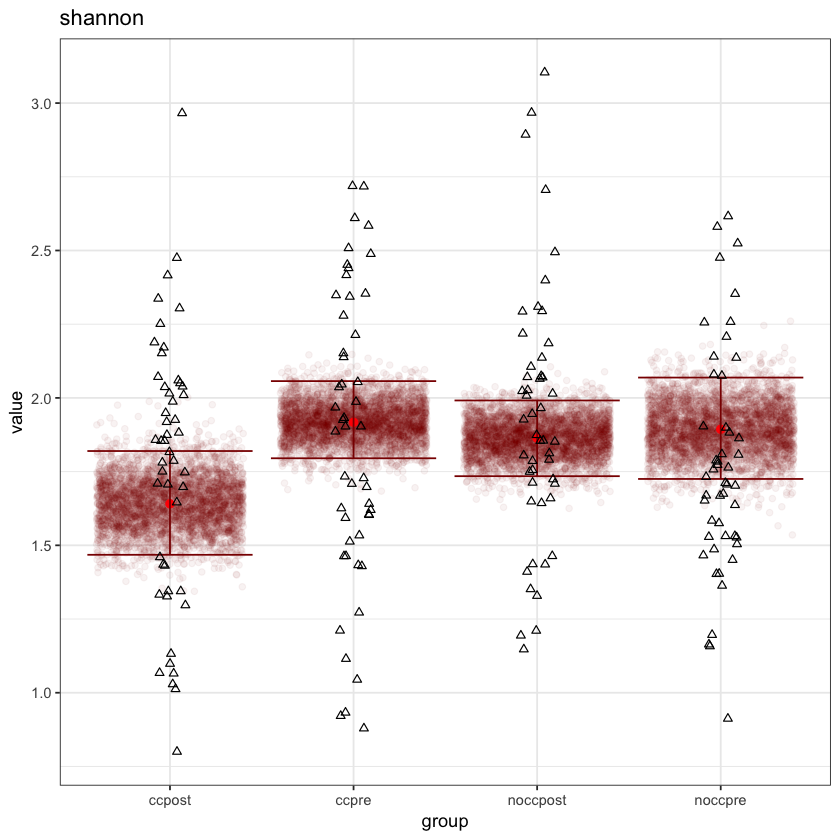

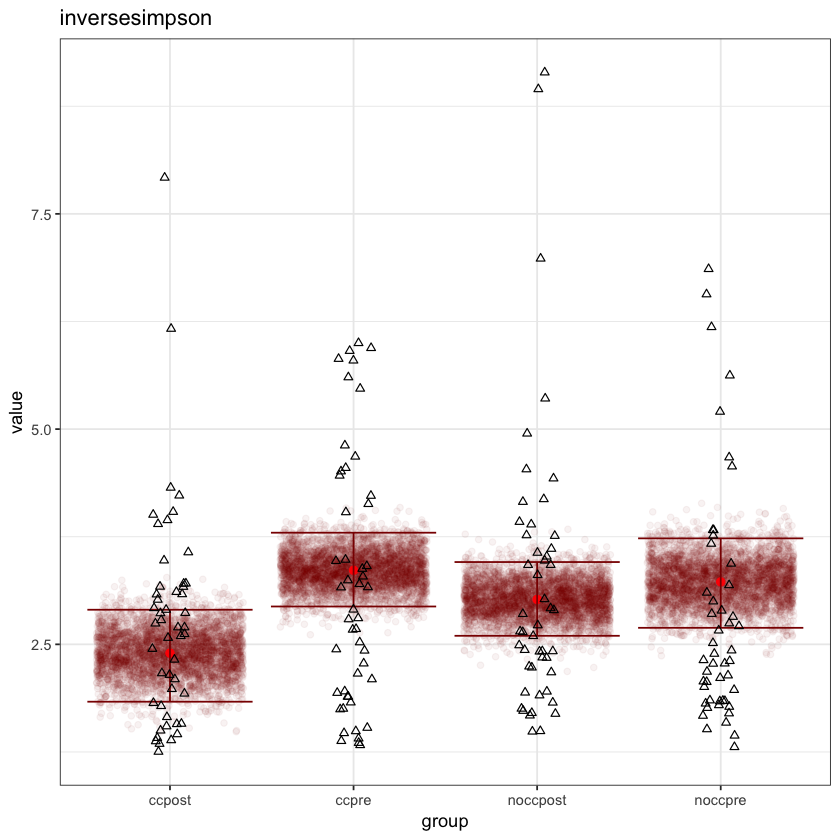

[[1]]

[[2]]

[[3]]

[[4]]


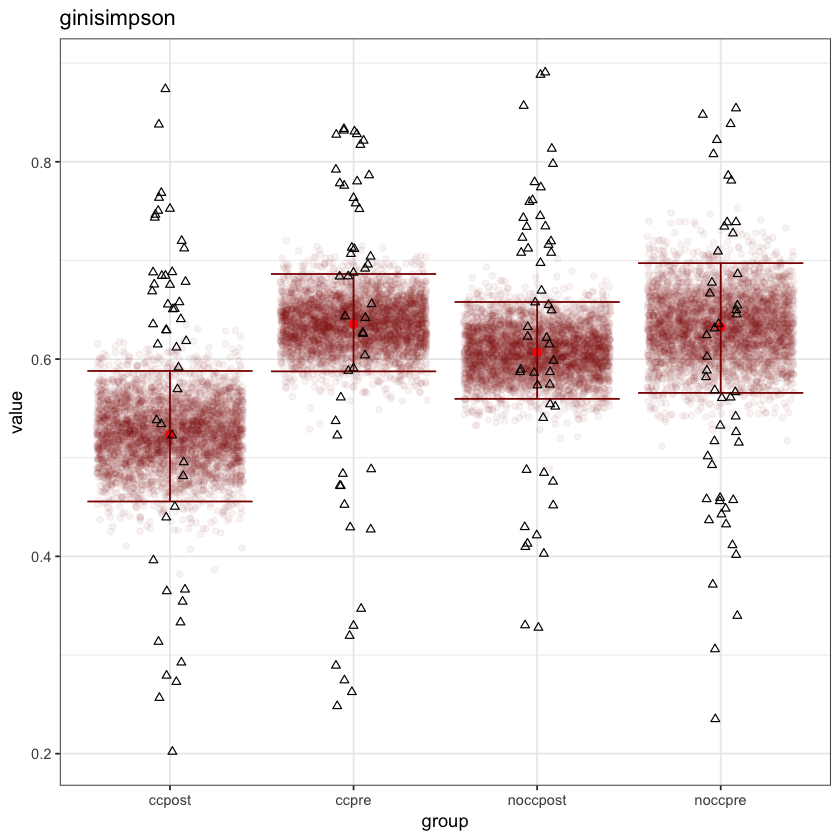

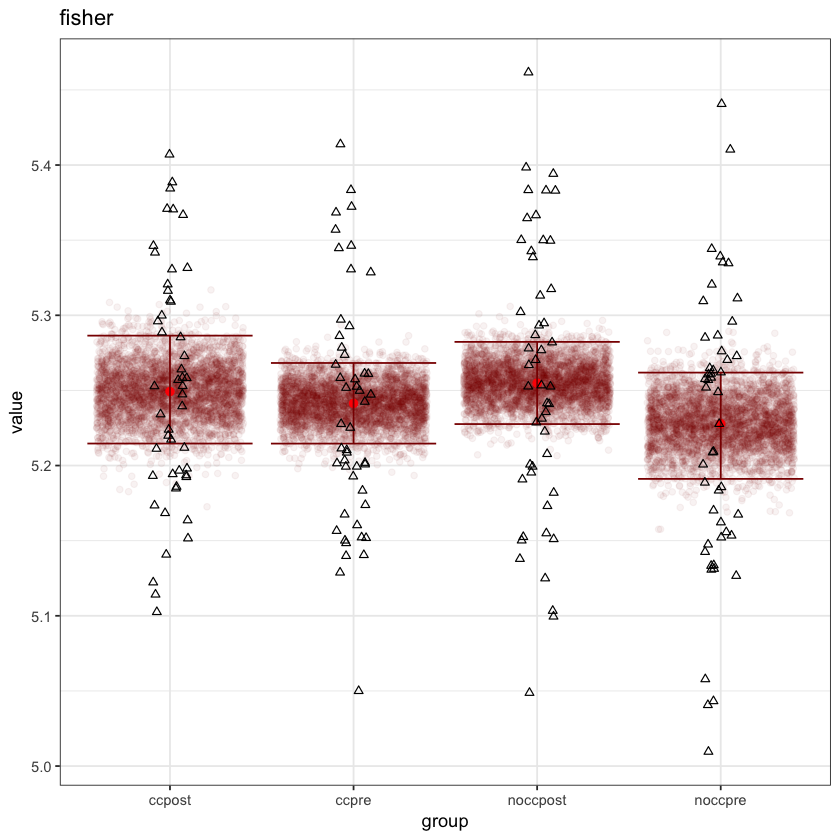

In [40]:
# visualize difference
meta <- meta %>% mutate(
    group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre")))
)
lapply(1:length(diversity_index), function(x) {
    p <- plot_effects(div_models_mi[[x]], diversity_index[x]) +
            geom_jitter(data = meta, aes_string("group", diversity_index[x]), width = 0.1, shape = 2)
    ggsave(here(glue("fig/parameter_plot_{x}.png")))
    p
    })

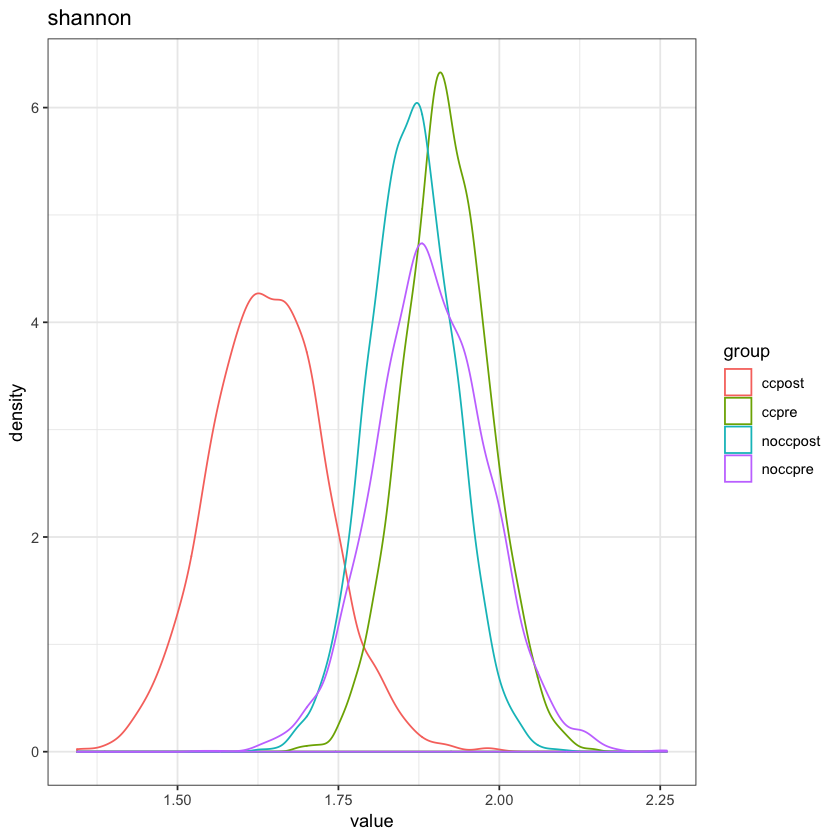

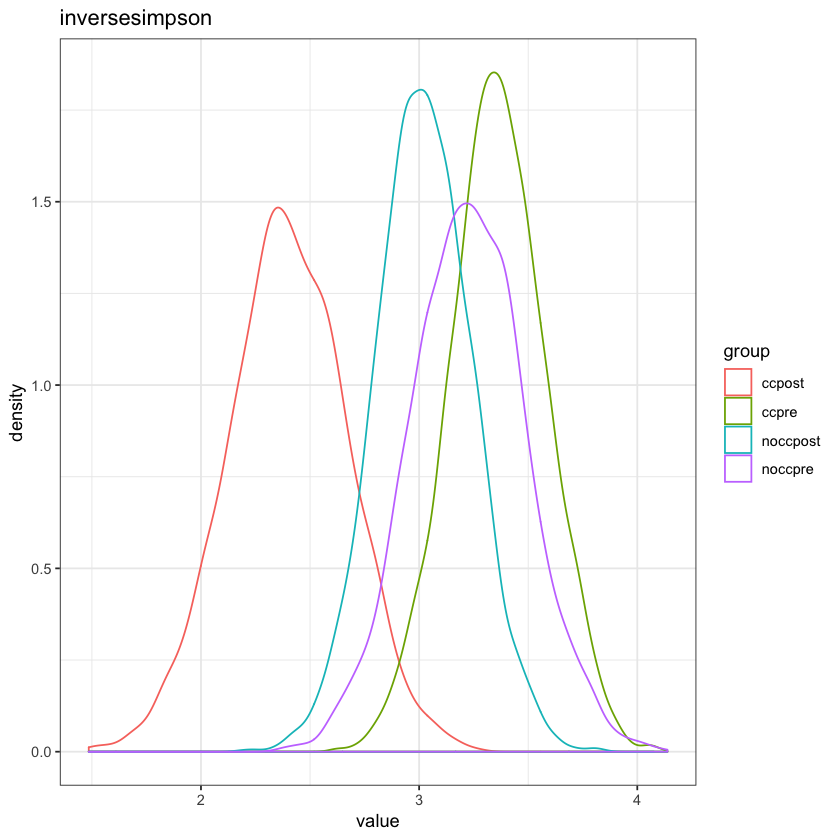

[[1]]

[[2]]

[[3]]

[[4]]


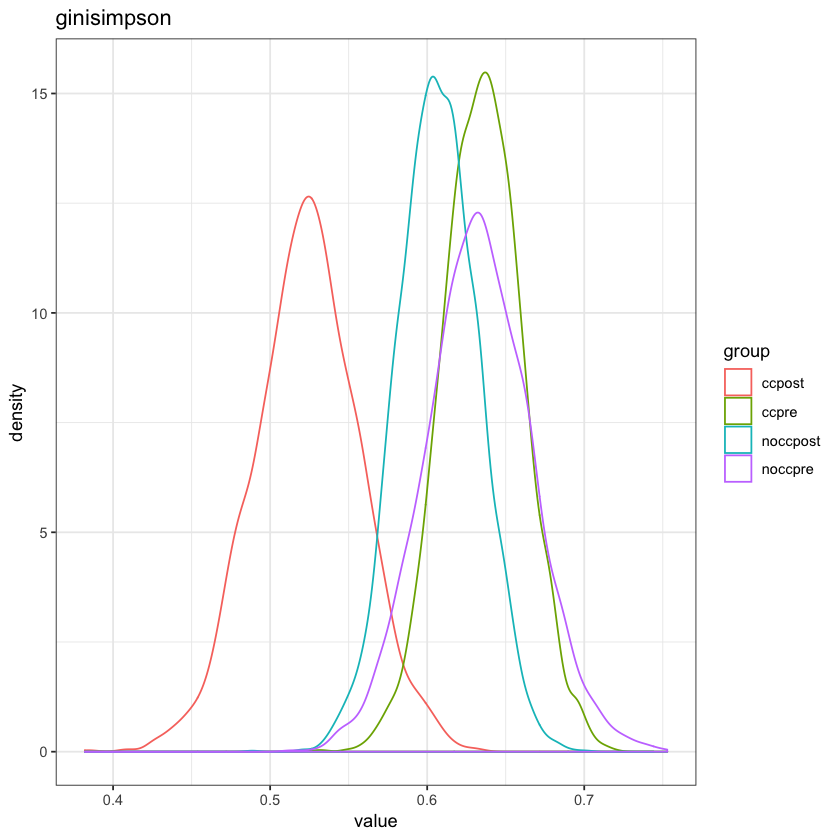

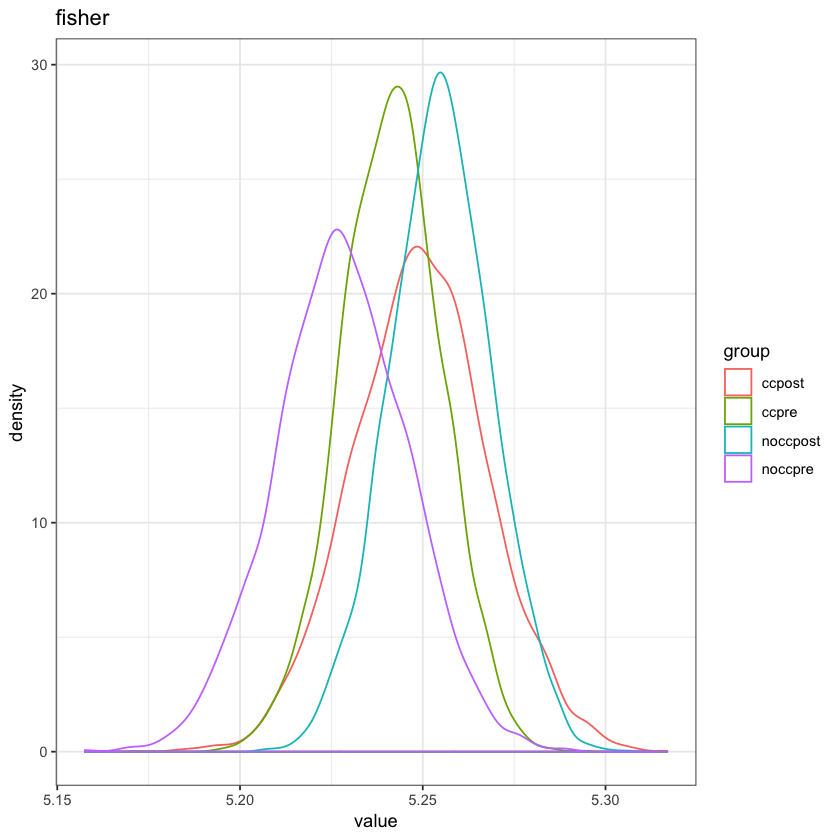

In [41]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df %>%
        gather(group, value) %>%
        ggplot(aes(value, color = group)) +
        geom_density() +
        ggtitle(var_name) +
        theme_bw()
})



# Differential abundance testing

In [42]:
# specify prior 
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/final_analyses/differential_abundance/")

# define fitting function for fixed sigma
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

# this function I added for the exluded_id (see below)
# define fitting function for fixed sigma
brm_sn_mi_ex <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(35)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(35)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [43]:
# can only always check a subset of models due to low memory
#models_sn <- lapply(genus, brm_sn_mi)

In [44]:
# remove models that did not fulfil diagnostic criteria
# lapply(genus[exclude_id], function(x) {
#     folder <- here("models/final_analyses/differential_abundance/skew_normal/")
#     file <- glue("{folder}{x}_full_mi.rds")
#     file.remove(file)
# })

In [45]:
# model screening/excluding skew_normal
exclude_id <- c()
for (i in 1:130) {
    fit <- brm_sn_mi(genus[i])
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]             
    # check if there are divergent transitions
    if (n_high_rhat > 0) {
        print(glue("{genus[i]} has {n_high_rhat} high Rhat parameter values"))
        exclude_id <- c(exclude_id, i)
    } else if (n_divergent$n > 0){
        print(glue("{genus[i]} has {n_divergent$n} divergent transitions"))
        exclude_id <- c(exclude_id, i)
    }     
}
genus_sel <- genus[-exclude_id]
# now I go back and again fit those models with stronger priors

Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Actinomycetaceae has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 21 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Butyrivibriocrossotusetrel has 5 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Catenibacteriummitsuokaietrel has 1 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 43 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Clostridiumnexileetrel has 10 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Clostridiumsphenoidesetrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 129 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

OutgroupingclostridiumclusterXIVa has 3 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Prevotellamelaninogenicaetrel has 2 high Rhat parameter values


Warning message:
“There were 21 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Ruminococcuslactarisetrel has 21 divergent transitions


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Subdoligranulumvariableatrel has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 45 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

UnculturedChroococcales has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”Warning message:
“There were 12 divergent transitions after warmup. Increasing adapt_delta above 0.9999 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

Vibrio has 2 high Rhat parameter values


Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

Wissellaetrel has 3 high Rhat parameter values


In [46]:
exclude_id

[1]   1  31  33  40  43  89  97 108 116 120 126 128

In [47]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost"), 
            glue("b_{var_name}_age_d_s"), 
            glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        rename(
            noccpre = glue("b_{var_name}_Intercept"), 
            ccpre = glue("b_{var_name}_ccyes"),
            noccpost = glue("b_{var_name}_timepost"),
            ccpost = glue("b_{var_name}_ccyes:timepost"),
            age = glue("b_{var_name}_age_d_s"),
            bf = glue("bsp_{var_name}_mibf_count_s")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}



In [48]:
age <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
bf <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_noccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
ccpost_noccpost <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpre_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpost_noccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
noccpost_ccpre <- tibble(genus = NA, mean = NA, lower = NA, upper = NA, prob = NA, effect = NA)
for (var_name in genus_sel) {
    fit <- brm_sn_mi(var_name)
    df <- calc_treatment_effect(fit, var_name, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            noccpre_ccpre = noccpre - ccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, noccpre_ccpre, noccpost_noccpre, noccpost_ccpre, age, bf) %>%
        gather(effect, value) %>%
        group_by(effect) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    age <- rbind(age, tibble(genus = var_name, mean = df$mean[1], lower = df$lower[1], upper = df$upper[1], prob = df$prob[1], effect = "age"))
    bf <- rbind(bf, tibble(genus = var_name, mean = df$mean[2], lower = df$lower[2], upper = df$upper[2], prob = df$prob[2], effect = "bf"))
    ccpost_ccpre <- rbind(ccpost_ccpre, tibble(genus = var_name, mean = df$mean[3], lower = df$lower[3], upper = df$upper[3], prob = df$prob[3], effect = "ccpost_ccpre"))
    ccpost_noccpre <- rbind(ccpost_noccpre, tibble(genus = var_name, mean = df$mean[4], lower = df$lower[4], upper = df$upper[4], prob = df$prob[4], effect = "ccpost_noccpre"))
    ccpost_noccpost <- rbind(ccpost_noccpost, tibble(genus = var_name, mean = df$mean[5], lower = df$lower[5], upper = df$upper[5], prob = df$prob[5], effect = "ccpost_noccpost"))
    noccpre_ccpre <- rbind(noccpre_ccpre, tibble(genus = var_name, mean = df$mean[6], lower = df$lower[6], upper = df$upper[6], prob = df$prob[6], effect = "noccpre_ccpre"))
    noccpost_noccpre <- rbind(noccpost_noccpre, tibble(genus = var_name, mean = df$mean[7], lower = df$lower[7], upper = df$upper[7], prob = df$prob[7], effect = "noccpost_noccpre"))
    noccpost_ccpre <- rbind(noccpost_ccpre, tibble(genus = var_name, mean = df$mean[8], lower = df$lower[8], upper = df$upper[8], prob = df$prob[8], effect = "noccpost_ccpre"))
}

age <- na.omit(age)
bf <- na.omit(bf)
ccpost_ccpre <- na.omit(ccpost_ccpre)
ccpost_noccpre <- na.omit(ccpost_noccpre)
ccpost_noccpost <- na.omit(ccpost_noccpost)
noccpre_ccpre <- na.omit(noccpre_ccpre)
noccpost_noccpre <- na.omit(noccpost_noccpre)
noccpost_ccpre <- na.omit(noccpost_ccpre)

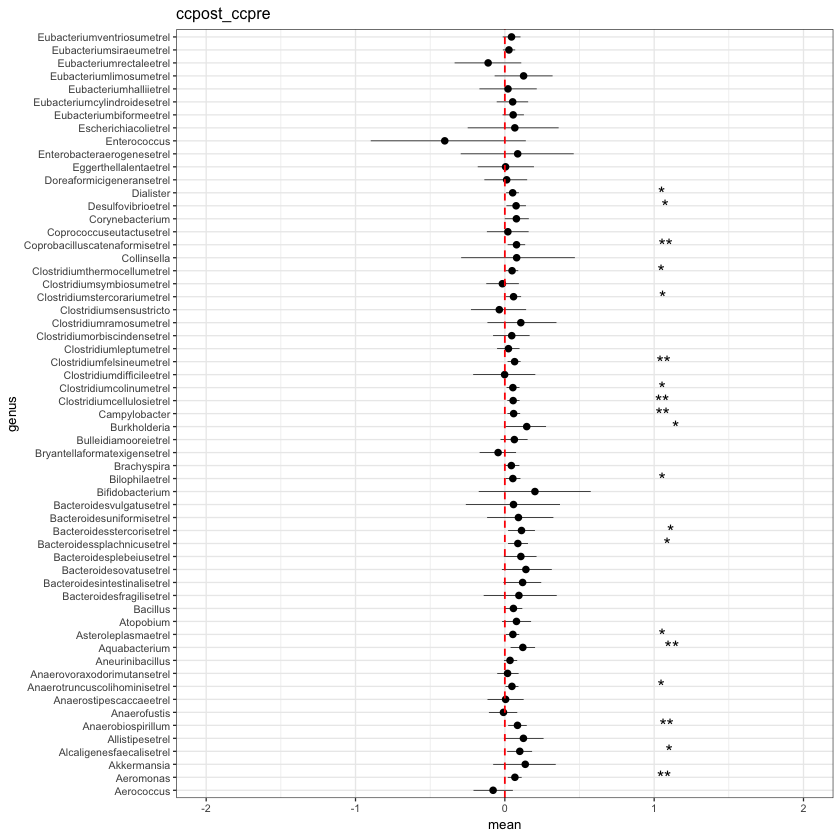

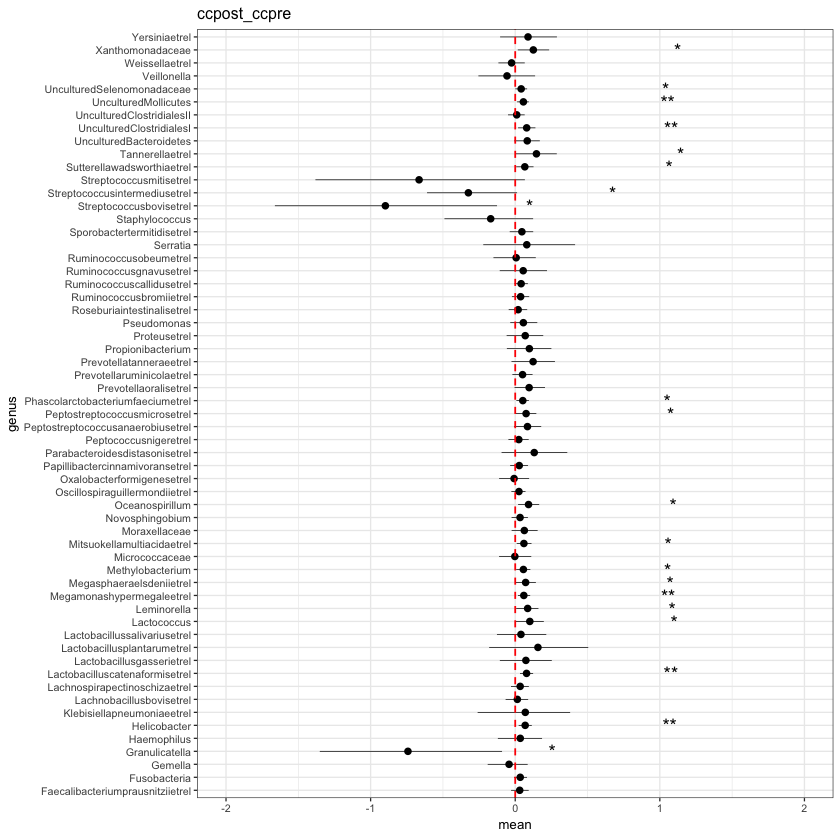

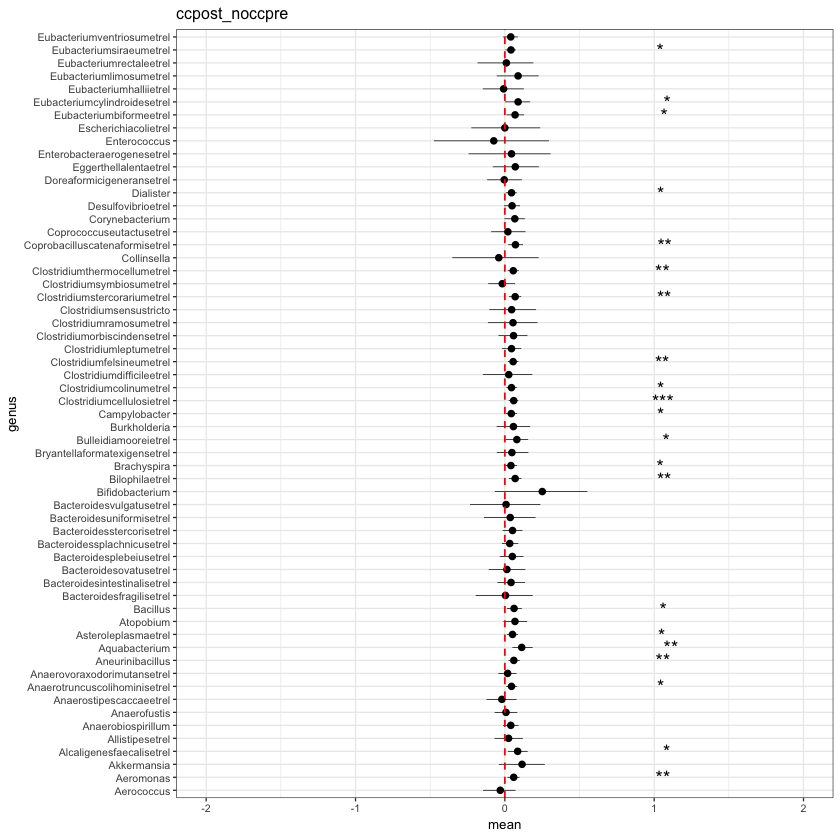

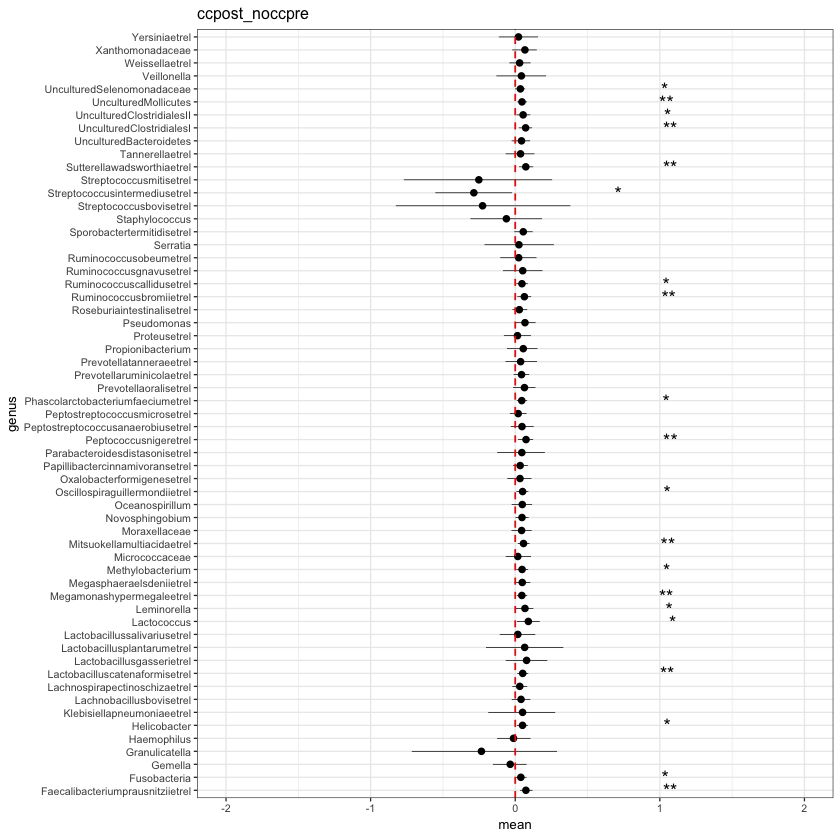

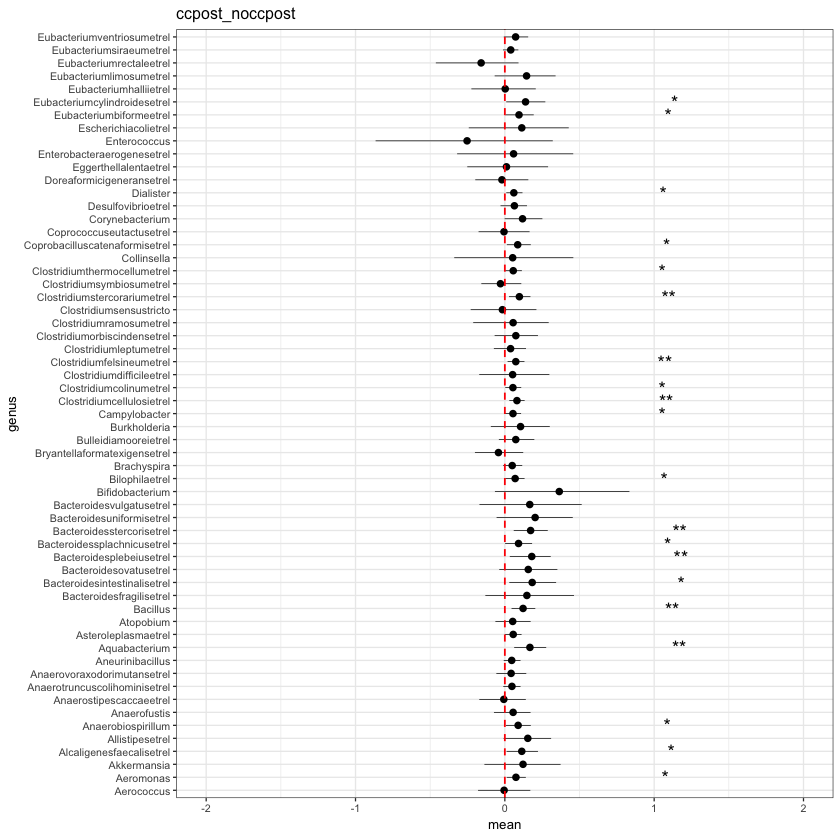

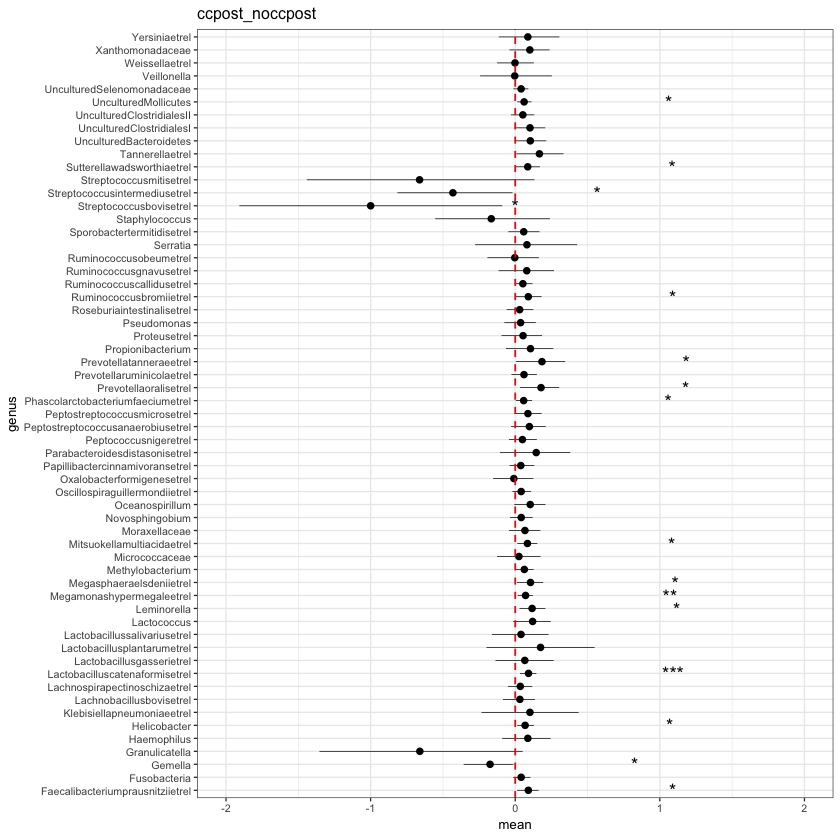

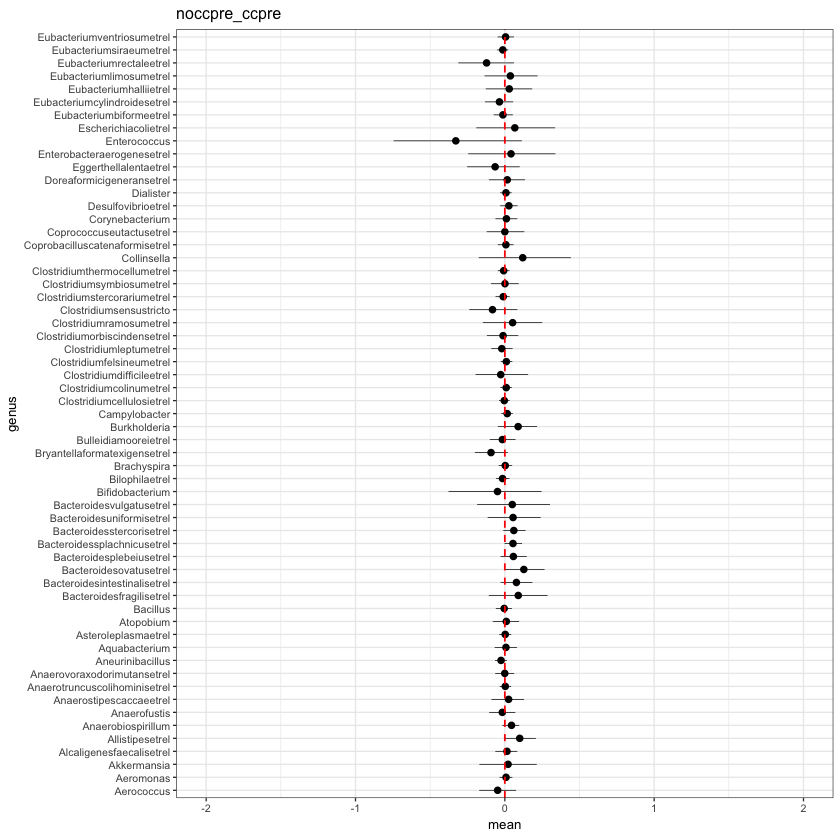

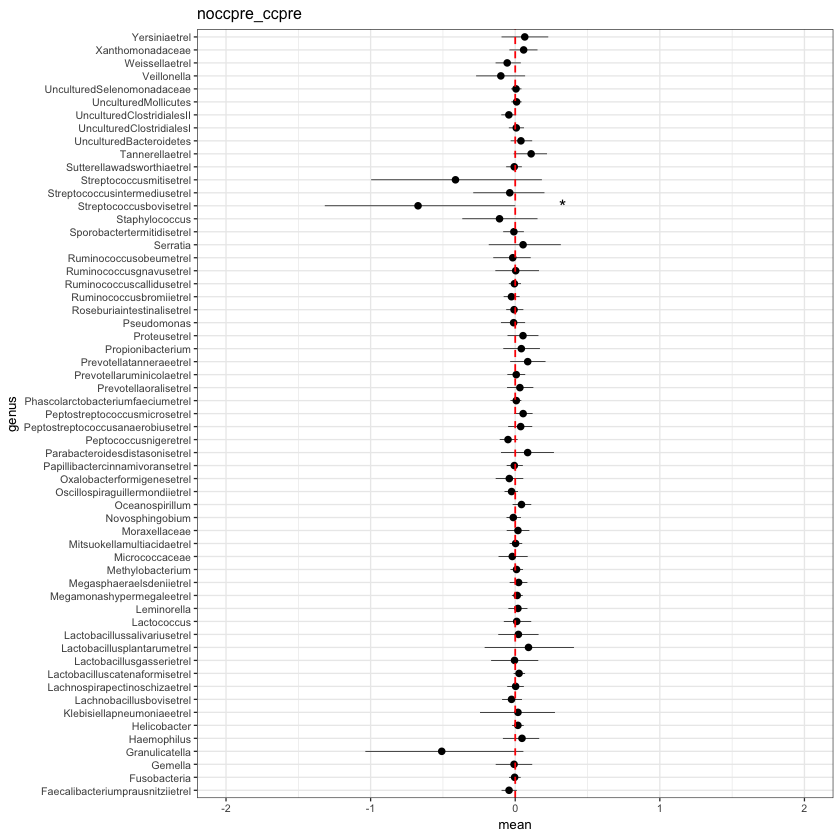

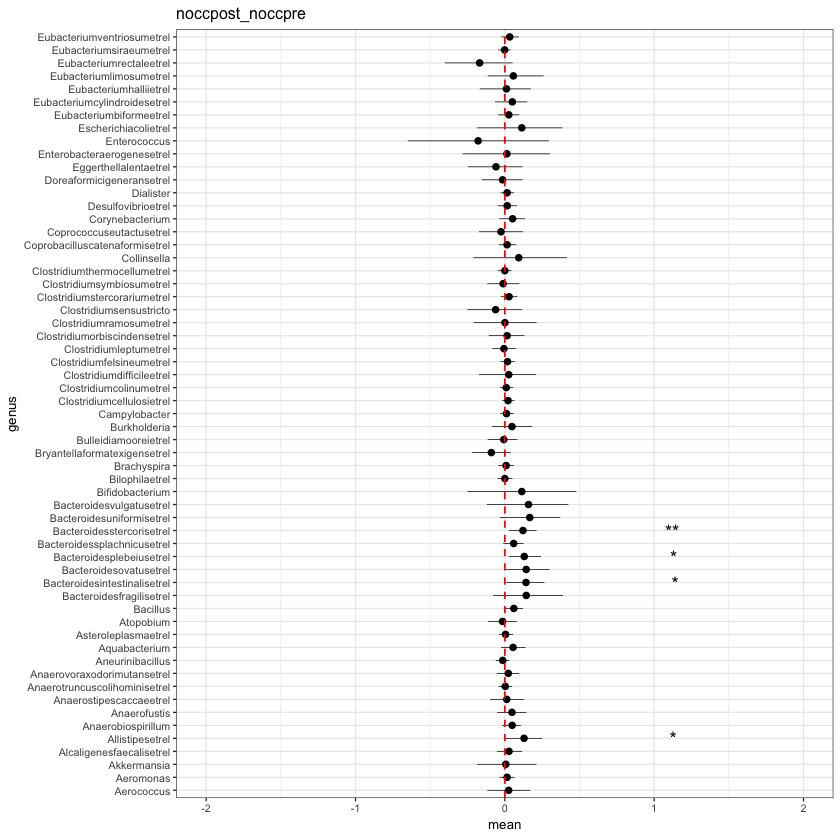

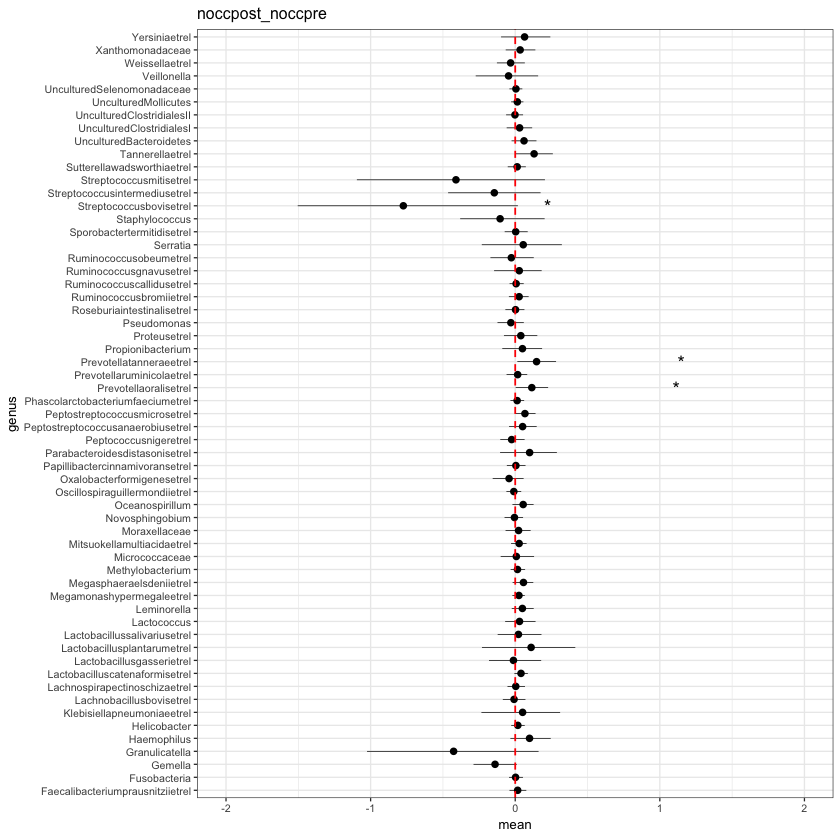

[[1]]
[[1]][[1]]

[[1]][[2]]


[[2]]
[[2]][[1]]

[[2]][[2]]


[[3]]
[[3]][[1]]

[[3]][[2]]


[[4]]
[[4]][[1]]

[[4]][[2]]


[[5]]
[[5]][[1]]

[[5]][[2]]


[[6]]
[[6]][[1]]

[[6]][[2]]



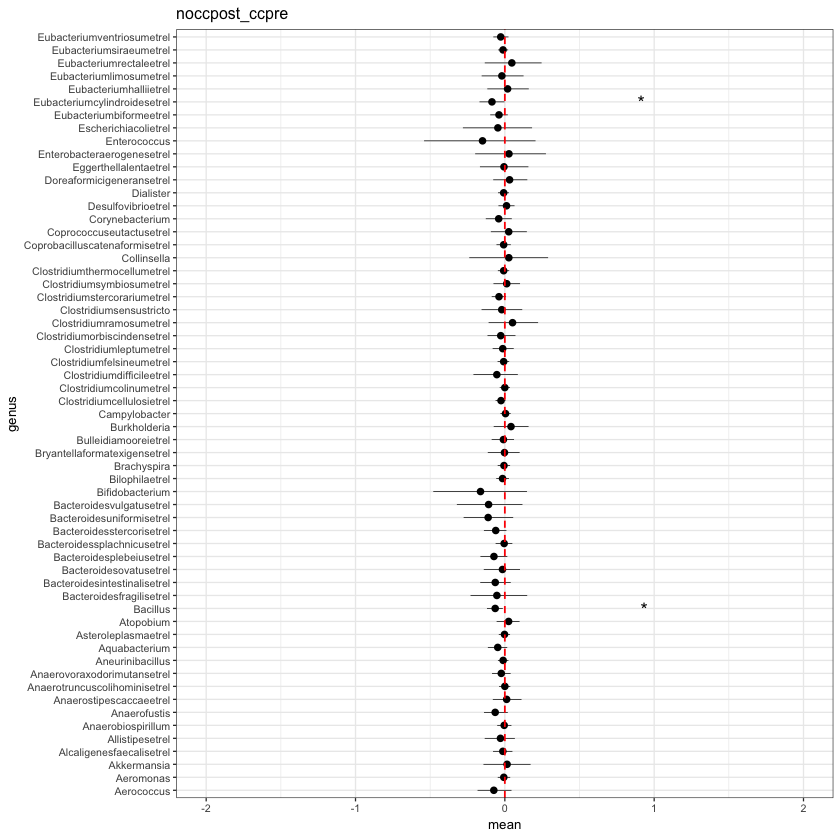

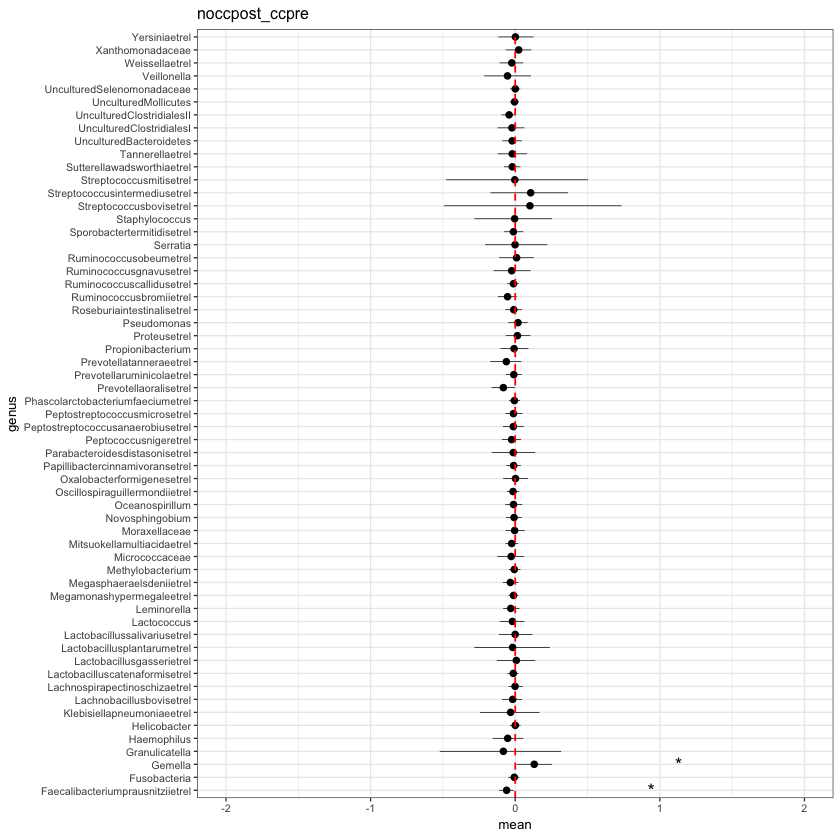

In [49]:
# how are effects distributed
dfs <- list(
    age = age, 
    bf = bf, 
    ccpost_ccpre = ccpost_ccpre, 
    ccpost_noccpre = ccpost_noccpre, 
    ccpost_noccpost = ccpost_noccpost,
    noccpre_ccpre = noccpre_ccpre,
    noccpost_noccpre = noccpost_noccpre,
    noccpost_ccpre = noccpost_ccpre
)
effects_vector <- c(
    "ccpost_ccpre", 
    "ccpost_noccpre",
    "ccpost_noccpost",
    "noccpre_ccpre",   
    "noccpost_noccpre",
    "noccpost_ccpre"
    )

lapply(effects_vector, function(x){
    df <- dfs[[x]] %>% mutate(prob = report_star_nondirectional(prob))
    df1 <- filter(df, genus %in% genus_sel[1:length(genus_sel)/2])
    df2 <- filter(df, genus %in% genus_sel[length(genus_sel)/2+1:length(genus_sel)])
    p1 <- ggplot(df1, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    
    p2 <- ggplot(df2, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        ggtitle(x) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        coord_flip() +
        theme_bw(base_size = 8)
    list(p1, p2)
})


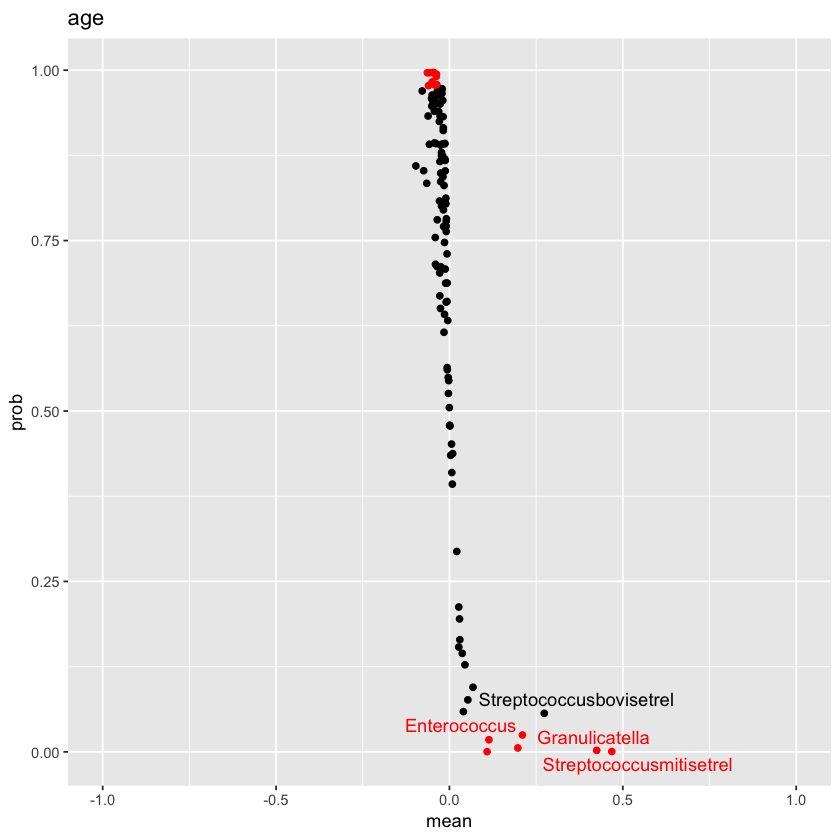

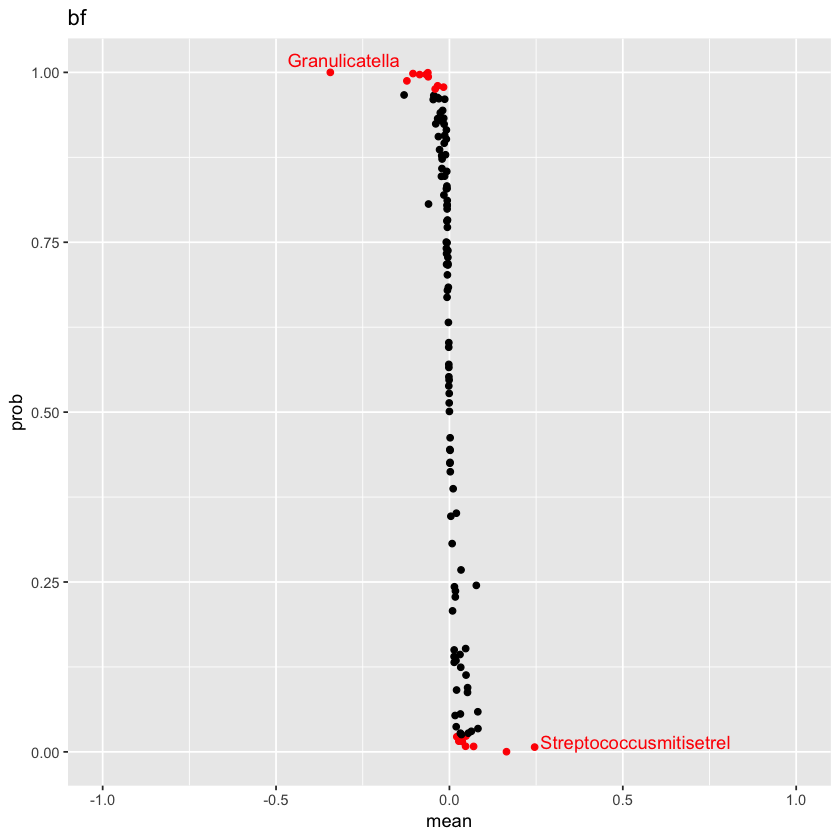

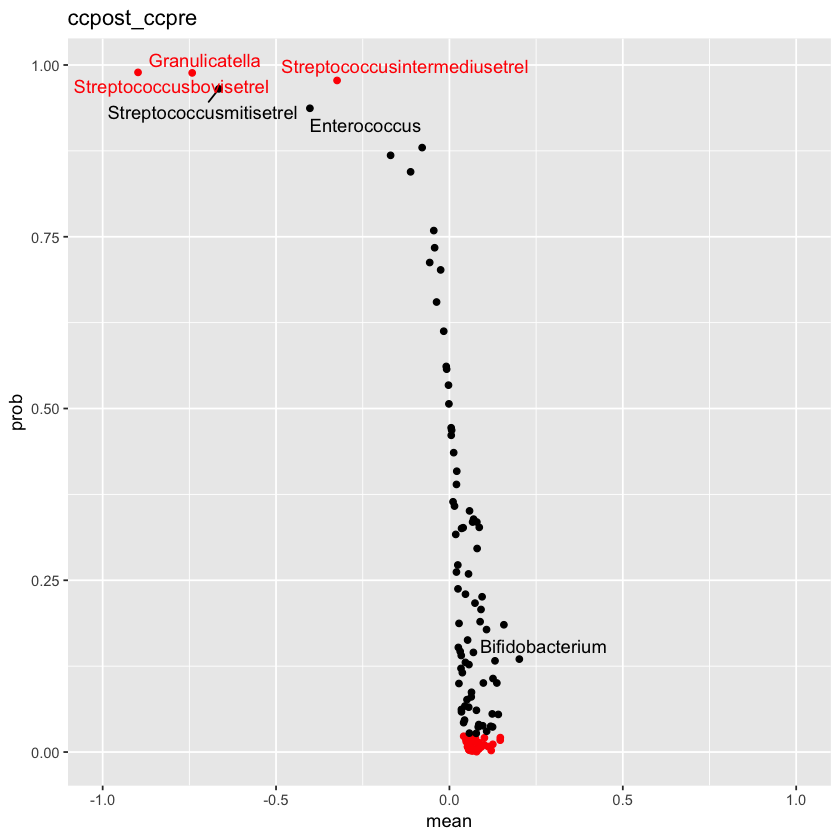

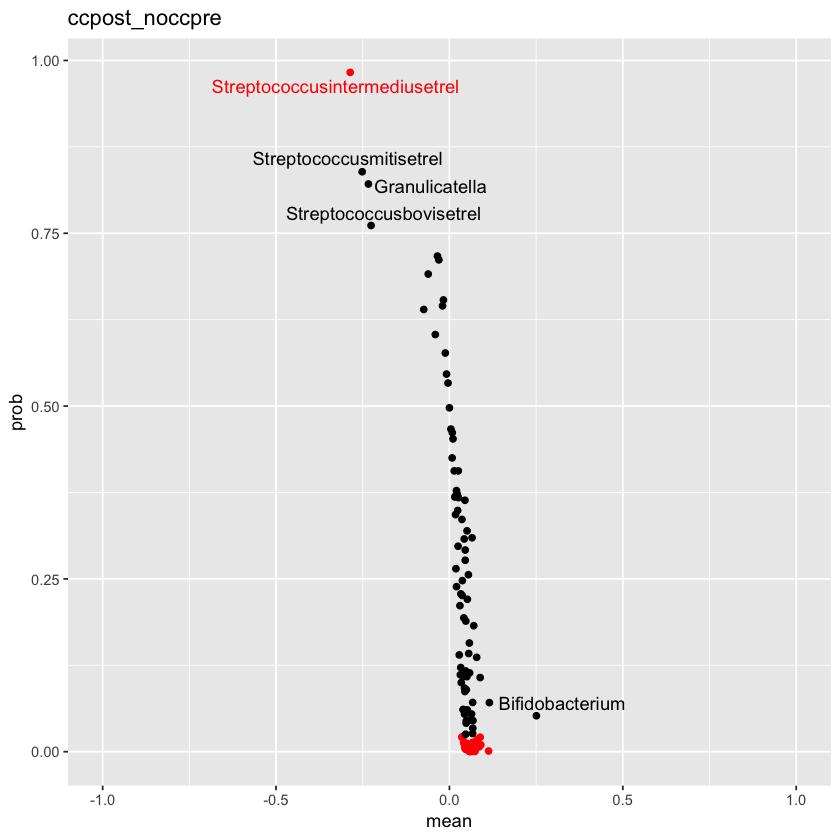

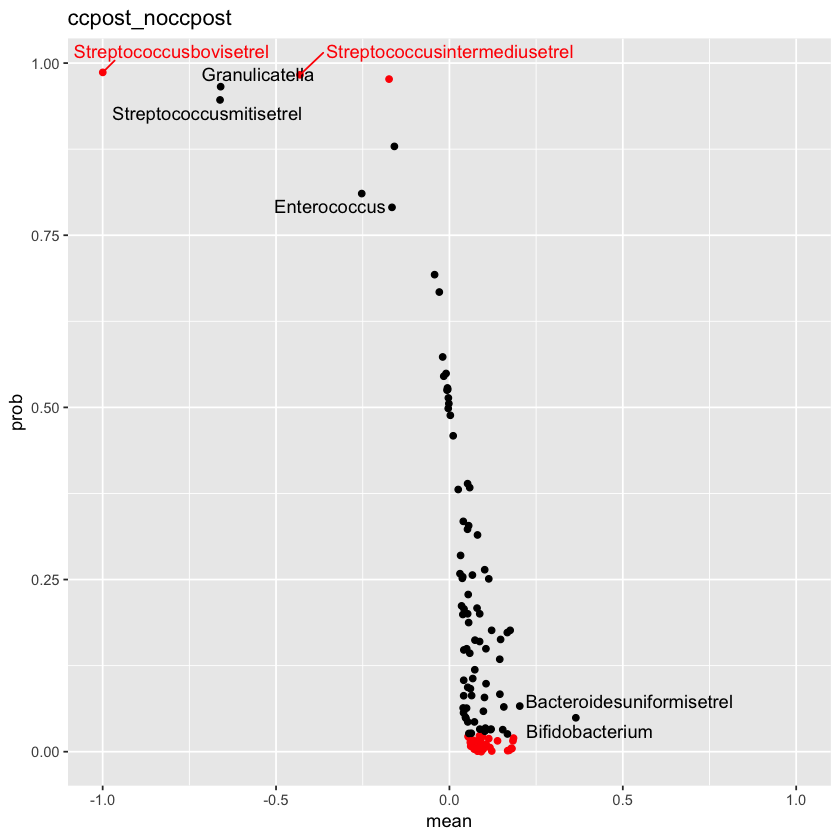

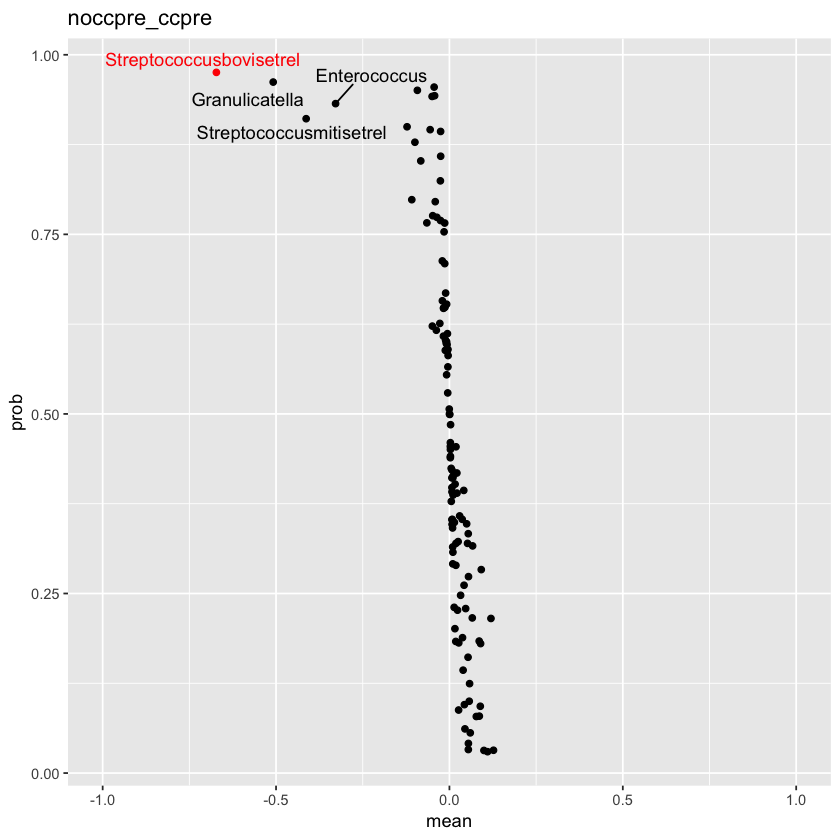

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


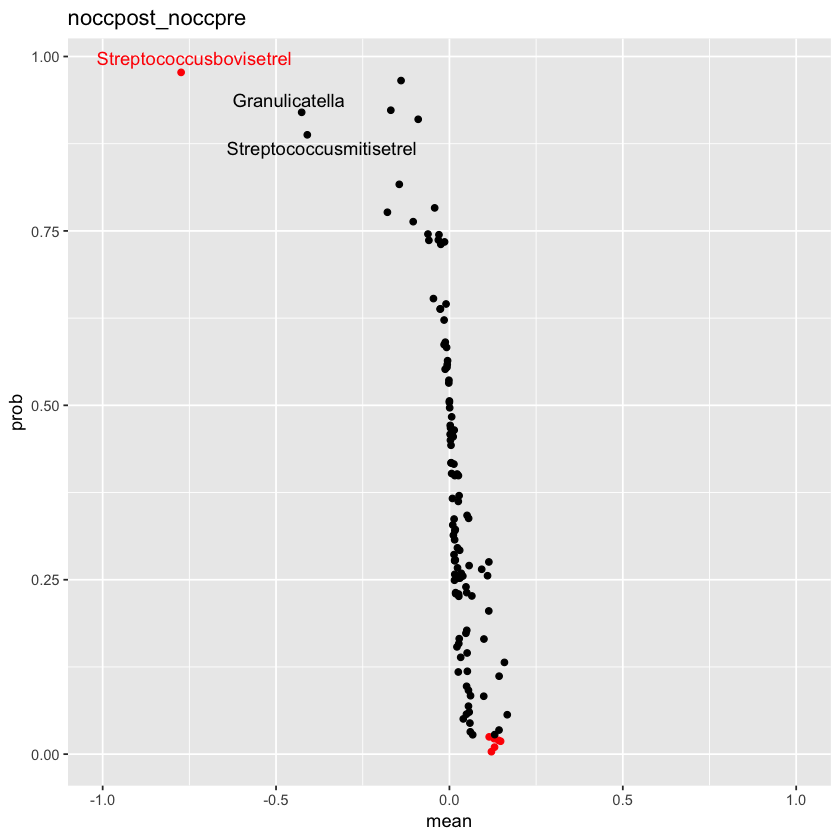

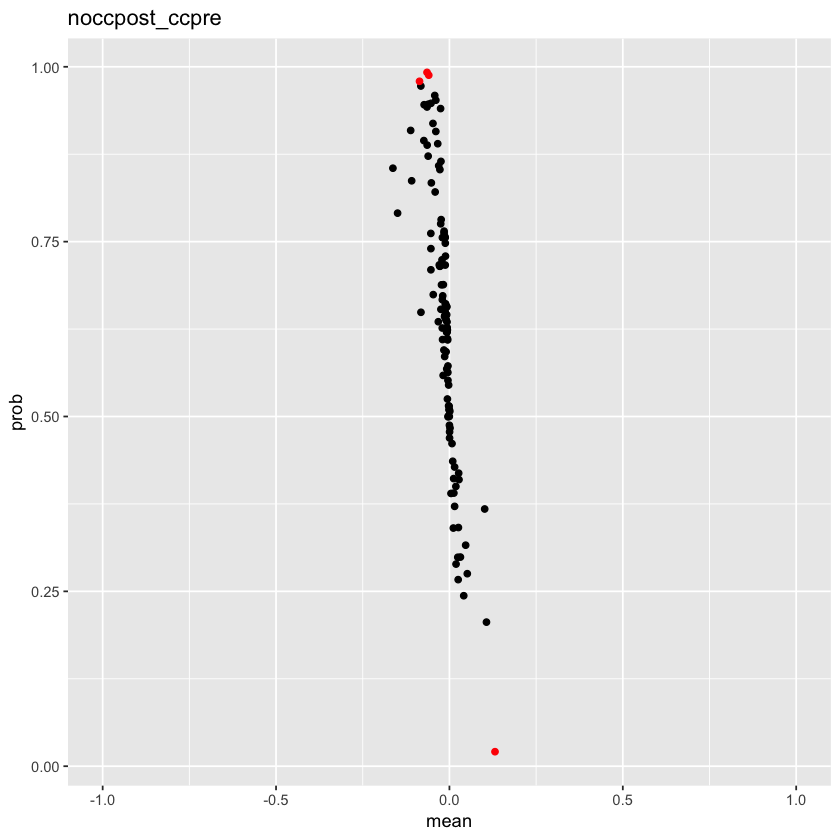

In [50]:
library(qvalue)
age <- age %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
bf <- bf %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_ccpre <- ccpost_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_noccpre <- ccpost_noccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
ccpost_noccpost <- ccpost_noccpost %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpre_ccpre <- noccpre_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpost_noccpre <- noccpost_noccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))
noccpost_ccpre <- noccpost_ccpre %>% 
    arrange(prob) %>%
    mutate(qvalue = cummean(prob))


effects <- rbind(age, bf, ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, noccpre_ccpre, noccpost_noccpre, noccpost_ccpre)

library(ggrepel)
lapply(effects$effect %>% unique(), function(x){
    effects %>% filter(effect == x) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.025 | prob >= 0.975, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
            geom_point() + 
            xlim(-1, 1) +
            ggtitle(x) +
            scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
            geom_text_repel() +
            theme(legend.position="none")
})


In [51]:
effects %>% 
    filter(prob < 0.025 | prob > 0.975) %>%
    group_by(effect) %>%
    summarise(n = n())

effect           n 
1 age              16
2 bf               20
3 ccpost_ccpre     39
4 ccpost_noccpost  36
5 ccpost_noccpre   41
6 noccpost_ccpre    4
7 noccpost_noccpre  7
8 noccpre_ccpre     1

In [52]:
data %>% group_by(groups) %>% summarise(mean = median(Streptococcusmitisetrel))

groups   mean    
1 CCpost   3.923501
2 CCpre    4.376024
3 noCCpost 3.951848
4 noCCpre  3.752681

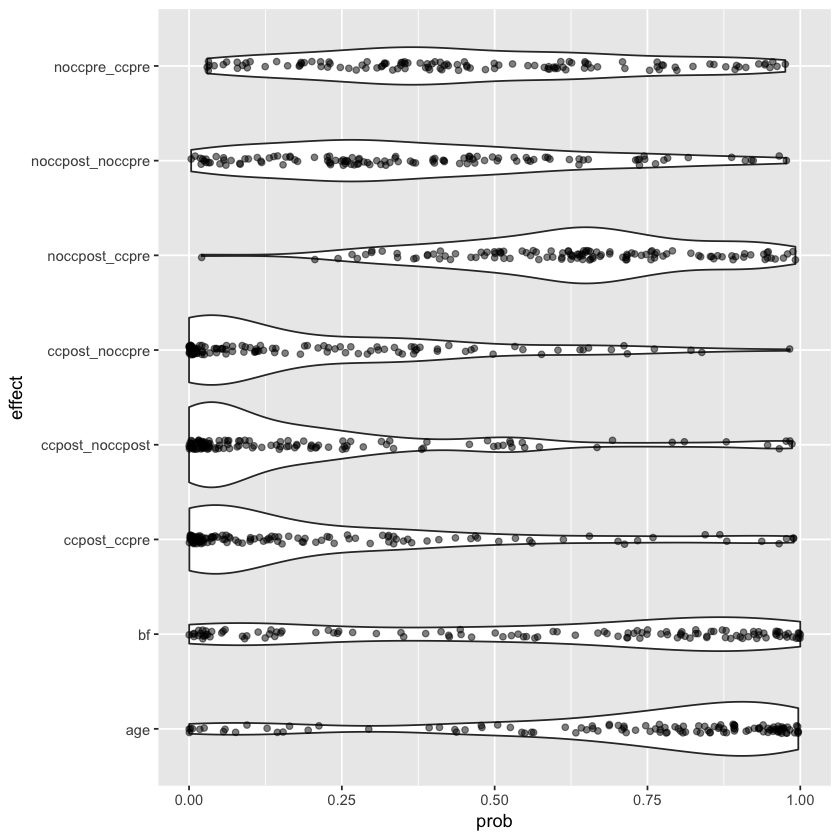

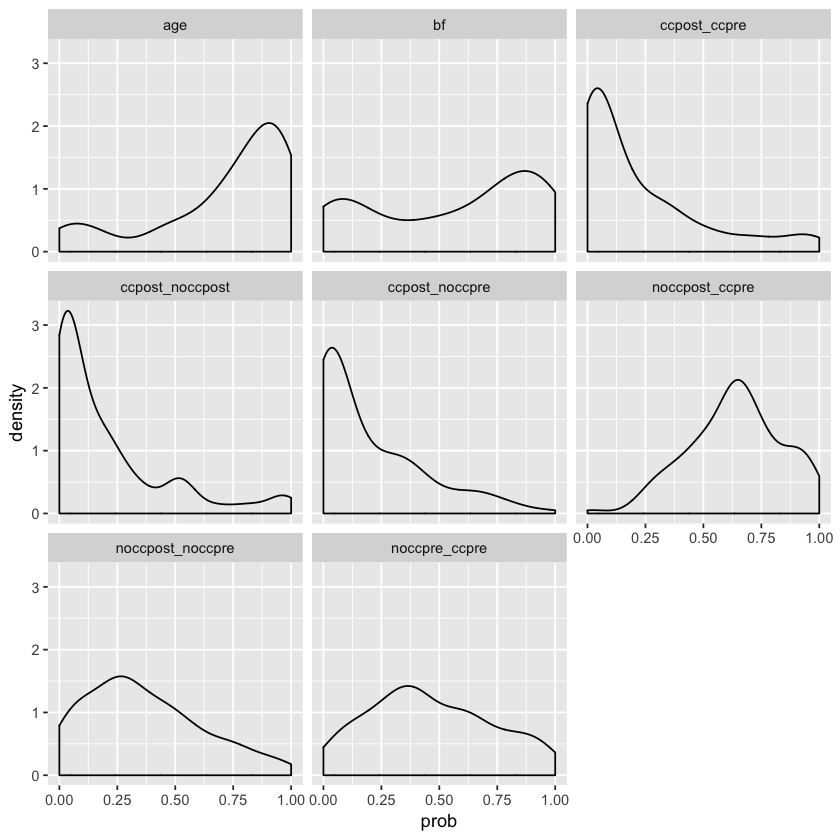

In [53]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
effects %>%
    ggplot(aes(effect, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

effects %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~effect)

## Non-parametric group comparison

In [54]:
ccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "CCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = TRUE, data = df)$p.value)
})

noccpre <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpre")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})

noccpost <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x) %>% 
        filter(groups %in% c("CCpost", "noCCpost")) %>%
        droplevels()
    
    colnames(df) <- c("groups", "genus")
    list(x =  wilcox.test(genus ~ groups, paired = FALSE, data = df)$p.value)
})


In [55]:
ccpre <- ccpre %>% as.tibble() %>% add_column(effect = "ccpre") %>% gather(genus, pvalue, -effect)
noccpre <- noccpre %>% as.tibble() %>% add_column(effect = "noccpre") %>% gather(genus, pvalue, -effect)
noccpost <- noccpost %>% as.tibble() %>% add_column(effect = "noccpost") %>% gather(genus, pvalue, -effect)

In [56]:
# qvalues
ccpre$q <- qvalue(ccpre$pvalue)$qvalues
noccpre$q <- qvalue(noccpre$pvalue, lambda = 0)$qvalues
noccpost$q <- qvalue(noccpost$pvalue)$qvalues
wilcox_result <- rbind(ccpre, noccpre, noccpost)

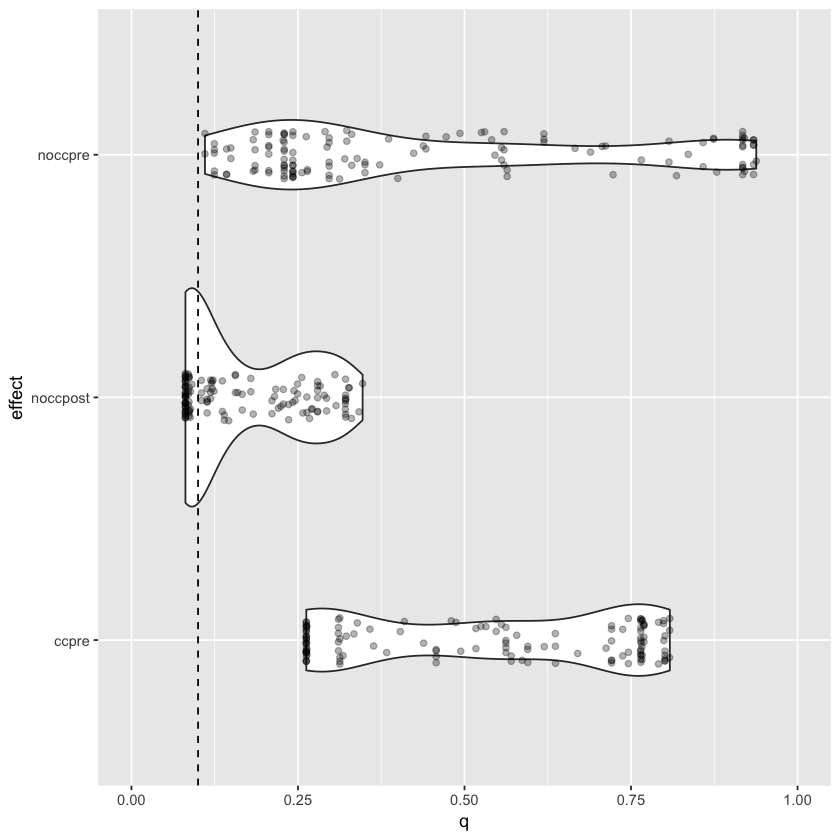

In [57]:
# distribution of p values:
wilcox_result %>%
    ggplot(aes(effect, q)) +
    geom_violin() +
    geom_jitter(width = 0.1, alpha = 0.3) +
    ylim(0, 1) +
    geom_hline(yintercept = 0.1, linetype = "dashed") +
    coord_flip()

[1] 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411
 [7] 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411 0.04448411
[13] 0.04448411 0.04448411 0.04448411 0.04826218

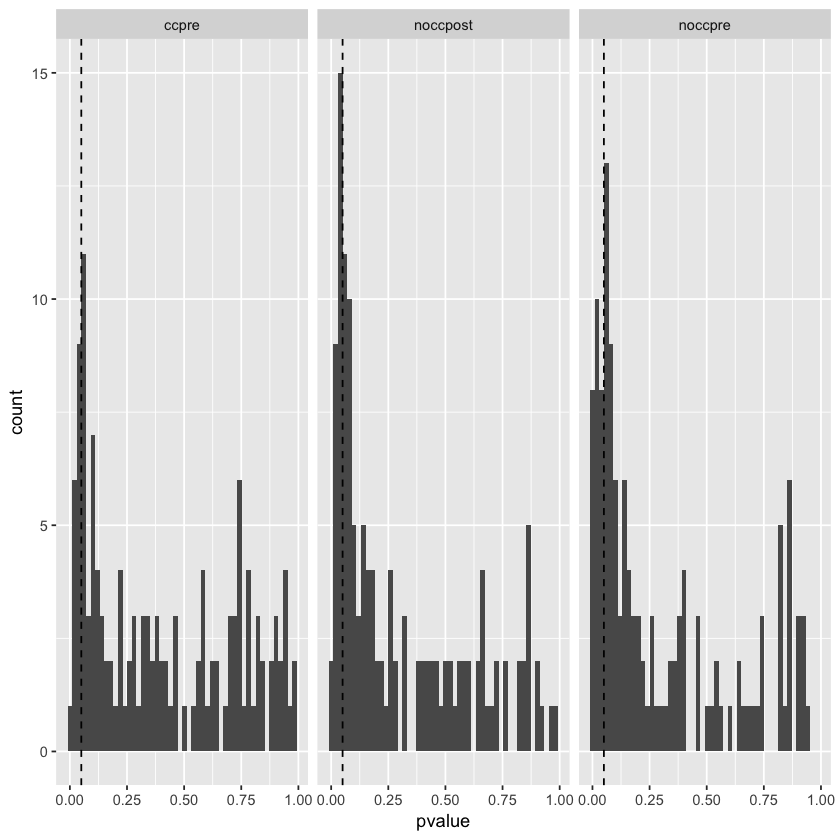

In [58]:
test <- 
    wilcox_result %>% 
        filter(pvalue <= 0.05, effect=="ccpre")  %>%
        arrange(pvalue)
qvalue(test$pvalue, lambda = 0)$qvalue

wilcox_result %>% 
    ggplot(aes(pvalue)) +
    geom_histogram(bins = 50) +
    geom_vline(xintercept = 0.05, linetype = "dashed") +
    facet_wrap(~effect)

In [59]:
kruskal <- sapply(genus, function(x) {
    df <- data %>% 
        select(groups, x)
    
    colnames(df) <- c("groups", "genus")
    list(x =  kruskal.test(genus~groups, data = df)$p.value)
})


In [60]:
kruskal <- kruskal %>% as.tibble() %>% gather(genus, pvalue) %>% arrange(pvalue)

In [61]:
kruskal$q <- qvalue(kruskal$pvalue, lambda = 0)$qvalues

## Frequentist hierarchical modeling

In [251]:
library(lme4)
library(car)
library(mice)
# i change contrasts to ease comparison, which is a bit different
# in frequentist setting
data_imp <-  data %>%
    select(-everything(), subject_id, age_d_s, time, cc, bf_count_s, sibling, Enterococcus, Staphylococcus, Bifidobacterium) %>%
    mice(m = 5, print = F)
# use example imputed data
data.f <- data
contrasts(data.f$cc)[1, 1] <- 1
contrasts(data.f$cc)[2, 1] <- 0
contrasts(data.f$time)[1, 1] <- 1
contrasts(data.f$time)[2, 1] <- 0

In [260]:
results <- list()
results_div <- list()
pms <- list()
for (i in 1:5) {
    data.f[c(rownames(data_imp$imp$bf_count_s)), "bf_count_s"] <- data_imp$imp$bf_count_s[, i]
    data.f[c(rownames(data_imp$imp$sibling)), "sibling"] <- data_imp$imp$sibling[, i]
    # lmes for differential abundance testing
    lme_fits <- 
        lapply(genus, function(x) {
            form <- glue("{x} ~ cc*time + age_d_s + bf_count_s + sibling + childsex + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(genus = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, genus)
            lme_fit
        })
    # lmes for diversity between and within groups
    lme_fits_div <- 
        lapply(diversity_index, function(x) {
            form <- glue("{x} ~ cc*time + age_d_s + bf_count_s + sibling + childsex + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(index = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, index)
            lme_fit
        })
    # manipulate data to have all in a list of dfs in the end
    # first for abundances
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    lme_cc <- lme_all %>% filter(effect == "cc")
    lme_time <- lme_all %>% filter(effect == "time")
    lme_age <- lme_all %>% filter(effect == "age_d_s")
    lme_bf <- lme_all %>% filter(effect == "bf_count_s")
    lme_cctime <- lme_all %>% filter(effect == "cc:time")
    lme_sibling <- lme_all %>% filter(effect == "sibling")
    lme_childsex <- lme_all %>% filter(effect == "childsex")
    # for divs
    lme_cc_div <- lme_all_div %>% filter(effect == "cc")
    lme_time_div <- lme_all_div %>% filter(effect == "time")
    lme_age_div <- lme_all_div %>% filter(effect == "age_d_s")
    lme_bf_div <- lme_all_div %>% filter(effect == "bf_count_s")
    lme_cctime_div <- lme_all_div %>% filter(effect == "cc:time")
    lme_sibling_div <- lme_all_div %>% filter(effect == "sibling")
    lme_childsex_div <- lme_all_div %>% filter(effect == "childsex")
    # add qvalues
    lme_fits <- lapply(list(lme_cc, lme_time, lme_age, lme_bf, lme_cctime, lme_sibling), function(df){
        df$q <- qvalue(df$`Pr..F.`)$qvalues
        df
    })
    lme_fits[[7]] <- lme_childsex$q <- qvalue(lme_childsex$`Pr..F.`, lambda = 0)$qvalues
    lme_fits_div <- lapply(list(lme_cc_div, lme_time_div, lme_age_div, lme_bf_div, lme_cctime_div, lme_sibling_div, lme_childsex_div), function(df){
        df$q <- qvalue(df$`Pr..F.`, lambda = 0)$qvalues
        df
    })
    # add all together
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    
    results[[i]] <- lme_all
    results_div[[i]] <- lme_all_div
    
    # permanova 
    pm <- adonis(data.f[, 18:147] ~ time * cc + age_d_s + bf_count_s + sibling + childsex, method = "euclidean", data = data.f[, 1:19])
    pms[[i]] <- pm$aov.tab %>% as.data.frame()
}

singular fit
singular fit
singular fit
singular fit
singular fit


In [265]:
results_q <- lapply(results, function(x) {
    filter(x, Pr..F. <= 0.05, q <= 0.3, effect == "cc")%>%
    arrange(estimate)
})
results_q_div <- lapply(results_div, function(x) {
    filter(x, Pr..F. <= 0.05, q <= 0.3) %>%
    arrange(estimate)
})
pms
results_q
results_q_div

[[1]]
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   57.32623  57.32623 1.4647662 0.007206881  0.110
cc           1   51.97663  51.97663 1.3280764 0.006534345  0.195
age_d_s      1   79.07412  79.07412 2.0204555 0.009940959  0.028
bf_count_s   1  219.14292 219.14292 5.5994114 0.027549986  0.001
sibling      1  102.53068 102.53068 2.6198037 0.012889847  0.004
childsex     1   47.83663  47.83663 1.2222936 0.006013877  0.255
time:cc      1   38.77352  38.77352 0.9907182 0.004874489  0.432
Residuals  188 7357.71436  39.13678        NA 0.924989615     NA
Total      195 7954.37510        NA        NA 1.000000000     NA

[[2]]
            Df  SumsOfSqs   MeanSqs  F.Model          R2 Pr(>F)
time         1   57.32623  57.32623 1.463550 0.007206881  0.128
cc           1   51.97663  51.97663 1.326974 0.006534345  0.178
age_d_s      1   79.07412  79.07412 2.018778 0.009940959  0.026
bf_count_s   1  211.92916 211.92916 5.410595 0.026643094  0.001
sibling      1   97.42759  97.42759 2.487346 0.012248302  0.010
childsex     1   52.13153  52.13153 1.330929 0.006553819  0.193
time:cc      1   40.68327  40.68327 1.038652 0.005114578  0.391
Residuals  188 7363.82656  39.16929       NA 0.925758022     NA
Total      195 7954.37510        NA       NA 1.000000000     NA

[[3]]
            Df  SumsOfSqs   MeanSqs  F.Model          R2 Pr(>F)
time         1   57.32623  57.32623 1.462770 0.007206881  0.120
cc           1   51.97663  51.97663 1.326267 0.006534345  0.156
age_d_s      1   79.07412  79.07412 2.017702 0.009940959  0.034
bf_count_s   1  202.62736 202.62736 5.170360 0.025473700  0.001
sibling      1  104.70101 104.70101 2.671613 0.013162695  0.004
childsex     1   49.43995  49.43995 1.261539 0.006215441  0.226
time:cc      1   41.47490  41.47490 1.058298 0.005214100  0.375
Residuals  188 7367.75488  39.19019       NA 0.926251879     NA
Total      195 7954.37510        NA       NA 1.000000000     NA

[[4]]
            Df  SumsOfSqs   MeanSqs  F.Model          R2 Pr(>F)
time         1   57.32623  57.32623 1.466146 0.007206881  0.152
cc           1   51.97663  51.97663 1.329327 0.006534345  0.173
age_d_s      1   79.07412  79.07412 2.022358 0.009940959  0.018
bf_count_s   1  215.94604 215.94604 5.522923 0.027148084  0.001
sibling      1  109.75817 109.75817 2.807118 0.013798466  0.005
childsex     1   48.23758  48.23758 1.233699 0.006064282  0.251
time:cc      1   41.26463  41.26463 1.055363 0.005187664  0.363
Residuals  188 7350.79169  39.09996       NA 0.924119319     NA
Total      195 7954.37510        NA       NA 1.000000000     NA

[[5]]
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   57.32623  57.32623 1.4649045 0.007206881  0.112
cc           1   51.97663  51.97663 1.3282018 0.006534345  0.164
age_d_s      1   79.07412  79.07412 2.0206462 0.009940959  0.023
bf_count_s   1  214.95374 214.95374 5.4928905 0.027023335  0.001
sibling      1  107.09799 107.09799 2.7367634 0.013464036  0.001
childsex     1   48.79717  48.79717 1.2469543 0.006134633  0.224
time:cc      1   38.12942  38.12942 0.9743525 0.004793515  0.445
Residuals  188 7357.01979  39.13308        NA 0.924902296     NA
Total      195 7954.37510        NA        NA 1.000000000     NA

[[1]]
   effect    estimate        F Df   Df.res      Pr..F.
1      cc -0.10869006 5.188015  1 92.54344 0.025045526
2      cc -0.08307175 5.898061  1 92.34218 0.017094529
3      cc -0.07687187 5.075722  1 92.53442 0.026626078
4      cc -0.07632925 8.217828  1 92.47726 0.005136246
5      cc -0.07562458 9.185724  1 92.40762 0.003163897
6      cc -0.07222563 8.957779  1 92.40836 0.003543676
7      cc -0.07036690 5.050426  1 92.55270 0.026995950
8      cc -0.06889870 4.109136  1 92.52386 0.045529562
9      cc -0.06878076 4.788230  1 92.34839 0.031178150
10     cc -0.06871771 5.077125  1 92.49764 0.026606644
11     cc -0.06760833 4.077507  1 92.30566 0.046357995
12     cc -0.06649454 5.443717  1 92.41779 0.021808254
13     cc -0.06632650 4.042166  1 92.51930 0.047288104
14     cc -0.06464437 7.064471  1 92.46989 0.009264392
15     cc -0.06447836 4.902385  1 92.49735 0.029277091
16     cc -0.06422004 4.524603  1 92.56124 0.036070044
17     cc -0.06092326 4.414875  1 92.52880 0.038345412
18     cc -0.06060649 4.450872  1 92.55740 0.037582026
19     cc -0.06033602 6.150489  1 92.57857 0.014945312
20     cc -0.05955460 3.978714  1 92.49493 0.049022242
21     cc -0.05905813 4.270489  1 92.51015 0.041574690
22     cc -0.05794868 4.620043  1 92.55467 0.034208697
23     cc -0.05759204 4.123151  1 92.49914 0.045171303
24     cc -0.05620136 4.100238  1 92.52907 0.045758929
25     cc -0.05588253 4.711778  1 92.47425 0.032517773
26     cc -0.05169384 4.345660  1 92.33449 0.039864261
                               genus         q X..i..
1                      Aquabacterium 0.2167500     NA
2      Prevotellamelaninogenicaetrel 0.2167500     NA
3                     Bilophilaetrel 0.2167500     NA
4       Clostridiumstercorariumetrel 0.1989764     NA
5   Faecalibacteriumprausnitziietrel 0.1989764     NA
6                           Bacillus 0.1989764     NA
7                   Aneurinibacillus 0.2167500     NA
8                          Aeromonas 0.2167500     NA
9       Eubacteriumcylindroidesetrel 0.2167500     NA
10         Clostridiumfelsineumetrel 0.2167500     NA
11             Prevotellaoralisetrel 0.2167500     NA
12           Ruminococcusbromiietrel 0.2167500     NA
13      Clostridiumthermocellumetrel 0.2167500     NA
14         Clostridiumcellulosietrel 0.2167500     NA
15         Megamonashypermegaleetrel 0.2167500     NA
16        Mitsuokellamultiacidaetrel 0.2167500     NA
17 Phascolarctobacteriumfaeciumetrel 0.2167500     NA
18     Anaerotruncuscolihominisetrel 0.2167500     NA
19         UnculturedClostridialesII 0.2167500     NA
20           Clostridiumcolinumetrel 0.2167500     NA
21                      Fusobacteria 0.2167500     NA
22         Ruminococcuscallidusetrel 0.2167500     NA
23                         Dialister 0.2167500     NA
24    Oscillospiraguillermondiietrel 0.2167500     NA
25           Eubacteriumsiraeumetrel 0.2167500     NA
26          Megasphaeraelsdeniietrel 0.2167500     NA

[[2]]
   effect    estimate        F Df   Df.res      Pr..F.
1      cc -0.14635317 3.997669  1 92.54702 0.048495721
2      cc -0.10932704 5.256489  1 92.64938 0.024128182
3      cc -0.08810650 6.337382  1 92.41954 0.013543770
4      cc -0.07964104 5.380036  1 92.63591 0.022566279
5      cc -0.07860557 8.652673  1 92.57300 0.004125746
6      cc -0.07686953 9.480539  1 92.49565 0.002733609
7      cc -0.07340891 9.210901  1 92.49916 0.003123858
8      cc -0.07328631 5.458909  1 92.65712 0.021624541
9      cc -0.07225282 4.903931  1 92.43593 0.029253911
10     cc -0.07142089 5.371358  1 92.59781 0.022673360
11     cc -0.07126954 4.328902  1 92.62307 0.040231428
12     cc -0.06977073 4.051590  1 92.54021 0.047035639
13     cc -0.06966428 4.178832  1 92.37996 0.043778234
14     cc -0.06941729 4.320808  1 92.62183 0.040414322
15     cc -0.06772095 5.623649  1 92.50983 0.019792965
16     cc -0.06745812 5.235445  1 92.59791 0.024406753
17     cc -0.06730877 4.929523  1 92.66382 0.028839961
18     cc -0.06653991 7.270384  1 92.57071 0.008328040

[[1]]
      effect    estimate        F Df    Df.res      Pr..F.           index
1    cc:time -0.78536180 5.934583  1  96.19167 0.016686919 inverse_simpson
2    cc:time -0.24798132 7.335722  1  96.21120 0.008001705         shannon
3    cc:time -0.08550030 5.692225  1  96.19149 0.018998723    gini_simpson
4 bf_count_s -0.01896837 6.893949  1 150.89720 0.009539694          fisher
           q
1 0.02533163
2 0.02533163
3 0.02533163
4 0.03815878

[[2]]
      effect    estimate        F Df    Df.res      Pr..F.           index
1    cc:time -0.82228921 6.539568  1  96.30090 0.012111275 inverse_simpson
2    cc:time -0.25770128 7.977969  1  96.34870 0.005755092         shannon
3    cc:time -0.08885184 6.119133  1  96.29685 0.015123599    gini_simpson
4 bf_count_s -0.01748440 5.688568  1 151.08199 0.018315725          fisher
          q
1 0.0201648
2 0.0201648
3 0.0201648
4 0.0732629

[[3]]
      effect    estimate        F Df    Df.res      Pr..F.           index
1    cc:time -0.81695049 6.434897  1  95.74315 0.012806718 inverse_simpson
2    cc:time -0.25897682 8.048286  1  95.71580 0.005559626         shannon
3    cc:time -0.08767845 5.971069  1  95.74453 0.016374023    gini_simpson
4 bf_count_s -0.01655805 5.455981  1 163.38898 0.020716200          fisher
           q
1 0.02183203
2 0.02183203
3 0.02183203
4 0.08286480

[[4]]
      effect    estimate        F Df    Df.res      Pr..F.           index
1    cc:time -0.81616588 6.495910  1  95.63353 0.012403863 inverse_simpson
2    cc:time -0.25944570 8.130201  1  95.57870 0.005334456         shannon
3    cc:time -0.08777190 6.027359  1  95.63788 0.015892521    gini_simpson
4 bf_count_s -0.01600647 4.957117  1 157.10640 0.027405984          fisher
           q
1 0.02119003
2 0.02119003
3 0.02119003
4 0.10962393

[[5]]
      effect   estimate        F Df    Df.res     Pr..F.           index
1    cc:time -0.8000901 6.101081  1  96.85938 0.01525888 inverse_simpson
2    cc:time -0.2464949 7.214758  1  96.95122 0.00850777         shannon
3    cc:time -0.0869060 5.827312  1  96.85667 0.01765817    gini_simpson
4 bf_count_s -0.0178671 5.995576  1 153.11776 0.01547070          fisher
           q
1 0.02354422
2 0.02354422
3 0.02354422
4 0.06188280

In [211]:
# check same with bf interaction
results <- list()
results_div <- list()
pms <- list()
for (i in 1:5) {
    data.f[c(rownames(data_imp$imp$bf_count_s)), "bf_count_s"] <- data_imp$imp$bf_count_s[, i]
    # lmes for differential abundance testing
    lme_fits <- 
        lapply(genus, function(x) {
            form <- glue("{x} ~ cc*time*bf_count_s + age_d_s + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(genus = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, genus)
            lme_fit
        })
    # lmes for diversity between and within groups
    lme_fits_div <- 
        lapply(diversity_index, function(x) {
            form <- glue("{x} ~ cc*time*bf_count_s + age_d_s + (1|subject_id)")
            l4fit <- lmer(form, data = data.f)
            estimates <- fixef(l4fit)  %>% as.tibble()
            lme_fit <- Anova(l4fit, test = "F", type = 2) %>% 
                        rownames_to_column("effect") %>%
                        add_column(estimate = estimates$value[-1]) %>%
                        add_column(index = x) %>%
                        select(effect, estimate, F, Df, Df.res, `Pr(>F)`, index)
            lme_fit
        })
    # manipulate data to have all in a list of dfs in the end
    # first for abundances
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    lme_cc <- lme_all %>% filter(effect == "cc")
    lme_time <- lme_all %>% filter(effect == "time")
    lme_age <- lme_all %>% filter(effect == "age_d_s")
    lme_bf <- lme_all %>% filter(effect == "bf_count_s")
    lme_cctime <- lme_all %>% filter(effect == "cc:time")
    # for divs
    lme_cc_div <- lme_all_div %>% filter(effect == "cc")
    lme_time_div <- lme_all_div %>% filter(effect == "time")
    lme_age_div <- lme_all_div %>% filter(effect == "age_d_s")
    lme_bf_div <- lme_all_div %>% filter(effect == "bf_count_s")
    lme_cctime_div <- lme_all_div %>% filter(effect == "cc:time")
    # add qvalues
    lme_fits <- lapply(list(lme_cc, lme_time, lme_age, lme_bf, lme_cctime), function(df){
        df$q <- qvalue(df$`Pr..F.`)$qvalues
        df
    })
    lme_fits_div <- lapply(list(lme_cc_div, lme_time_div, lme_age_div, lme_bf_div, lme_cctime_div), function(df){
        df$q <- qvalue(df$`Pr..F.`, lambda = 0)$qvalues
        df
    })
    # add all together
    lme_all <- plyr::ldply(lme_fits, data.frame)
    lme_all_div <- plyr::ldply(lme_fits_div, data.frame)
    
    results[[i]] <- lme_all
    results_div[[i]] <- lme_all_div
    
    # permanova 
    pm <- adonis(data.f[, 18:147] ~ time * cc * bf_count_s + age_d_s, method = "euclidean", data = data.f[, 1:10] )
    pms[[i]] <- pm$aov.tab %>% as.data.frame()
}

singular fit
singular fit
singular fit
singular fit
singular fit


In [212]:
results_q <- lapply(results, function(x) {
    filter(x, Pr..F. <= 0.05, q <= 0.25)%>%
    arrange(estimate)
})
results_q_div <- lapply(results_div, function(x) {
    filter(x, Pr..F. <= 0.05, q <= 0.25) %>%
    arrange(estimate)
})
pms
results_q
results_q_div

[[1]]
                    Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time                 1   58.44387  58.44387 1.4698050 0.007321525  0.141
cc                   1   52.63601  52.63601 1.3237433 0.006593950  0.167
bf_count_s           1  225.90028 225.90028 5.6811671 0.028299543  0.001
age_d_s              1   76.03753  76.03753 1.9122681 0.009525563  0.027
time:cc              1   37.10497  37.10497 0.9331531 0.004648307  0.488
time:bf_count_s      1   35.51512  35.51512 0.8931698 0.004449138  0.555
cc:bf_count_s        1   35.64897  35.64897 0.8965361 0.004465907  0.530
time:cc:bf_count_s   1   25.50221  25.50221 0.6413552 0.003194776  0.831
Residuals          187 7435.68207  39.76301        NA 0.931501292     NA
Total              195 7982.47102        NA        NA 1.000000000     NA

[[2]]
                    Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time                 1   58.44387  58.44387 1.4666651 0.007321525  0.106
cc                   1   52.63601  52.63601 1.3209154 0.006593950  0.185
bf_count_s           1  210.12683 210.12683 5.2731914 0.026323531  0.001
age_d_s              1   76.35167  76.35167 1.9160666 0.009564917  0.034
time:cc              1   36.53808  36.53808 0.9169333 0.004577289  0.493
time:bf_count_s      1   41.56455  41.56455 1.0430739 0.005206977  0.371
cc:bf_count_s        1   30.99553  30.99553 0.7778416 0.003882950  0.632
time:cc:bf_count_s   1   24.21378  24.21378 0.6076516 0.003033369  0.854
Residuals          187 7451.60071  39.84813        NA 0.933495491     NA
Total              195 7982.47102        NA        NA 1.000000000     NA

[[3]]
                    Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time                 1   58.44387  58.44387 1.4695340 0.007321525  0.125
cc                   1   52.63601  52.63601 1.3234992 0.006593950  0.190
bf_count_s           1  217.29515 217.29515 5.4637492 0.027221540  0.001
age_d_s              1   77.21725  77.21725 1.9415789 0.009673352  0.040
time:cc              1   38.65482  38.65482 0.9719510 0.004842463  0.438
time:bf_count_s      1   40.41196  40.41196 1.0161332 0.005062588  0.408
cc:bf_count_s        1   31.72950  31.72950 0.7978183 0.003974897  0.633
time:cc:bf_count_s   1   29.02932  29.02932 0.7299240 0.003636634  0.729
Residuals          187 7437.05314  39.77034        NA 0.931673052     NA
Total              195 7982.47102        NA        NA 1.000000000     NA

[[4]]
                    Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time                 1   58.44387  58.44387 1.4717419 0.007321525  0.136
cc                   1   52.63601  52.63601 1.3254877 0.006593950  0.178
bf_count_s           1  226.47565 226.47565 5.7031426 0.028371621  0.001
age_d_s              1   75.66943  75.66943 1.9055187 0.009479450  0.033
time:cc              1   36.74450  36.74450 0.9253052 0.004603148  0.494
time:bf_count_s      1   39.67256  39.67256 0.9990403 0.004969960  0.450
cc:bf_count_s        1   36.66297  36.66297 0.9232524 0.004592936  0.501
time:cc:bf_count_s   1   30.26972  30.26972 0.7622564 0.003792023  0.676
Residuals          187 7425.89631  39.71068        NA 0.930275387     NA
Total              195 7982.47102        NA        NA 1.000000000     NA

[[5]]
                    Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time                 1   58.44387  58.44387 1.4722837 0.007321525  0.117
cc                   1   52.63601  52.63601 1.3259757 0.006593950  0.177
bf_count_s           1  229.69993 229.69993 5.7864664 0.028775542  0.001
age_d_s              1   75.69845  75.69845 1.9069511 0.009483085  0.035
time:cc              1   36.67758  36.67758 0.9239602 0.004594765  0.515
time:bf_count_s      1   38.42504  38.42504 0.9679811 0.004813677  0.421
cc:bf_count_s        1   36.05630  36.05630 0.9083092 0.004516934  0.534
time:cc:bf_count_s   1   31.67038  31.67038 0.7978217 0.003967490  0.642
Residuals          187 7423.16348  39.69606        NA 0.929933032     NA
Total              195 7

[[1]]
       effect     estimate         F Df    Df.res       Pr..F.
1     cc:time -1.150207284  7.870342  1 122.48611 5.846842e-03
2     cc:time -0.873905572  5.257557  1 121.51941 2.357079e-02
3  bf_count_s -0.396650091  4.297858  1 141.01256 3.998040e-02
4     cc:time -0.171851294  7.028519  1 122.77902 9.079818e-03
5          cc -0.152397897  4.038173  1  93.19516 4.737398e-02
6     age_d_s -0.142438094  4.407482  1  95.56074 3.841707e-02
7  bf_count_s -0.137311366  4.834083  1 165.42822 2.929056e-02
8        time -0.136913789  4.997465  1 145.03713 2.691220e-02
9  bf_count_s -0.136288731  3.911370  1 177.36647 4.950945e-02
10 bf_count_s -0.131009939  4.016442  1 145.51240 4.691455e-02
11    cc:time -0.128720136  5.890185  1 115.90612 1.676532e-02
12         cc -0.128630567  5.967740  1  93.27951 1.645257e-02
13       time -0.118353106  6.273540  1 126.90406 1.352263e-02
14 bf_count_s -0.111261760  5.193343  1 137.82179 2.421058e-02
15    age_d_s -0.102866933  4.149307  1 101.27658 4.426037e-02
16 bf_count_s -0.093311659  8.660166  1 171.72093 3.702180e-03
17       time -0.088358492  4.723636  1 145.45168 3.136916e-02
18 bf_count_s -0.086735503 16.826147  1 184.03307 6.144897e-05
19       time -0.086529483  5.471593  1 151.31610 2.063558e-02
20    age_d_s -0.085992213  8.493921  1  96.95243 4.424922e-03
21         cc -0.085341586  4.952215  1  93.29848 2.846668e-02
22       time -0.084463472  4.748161  1 146.79856 3.092463e-02
23         cc -0.083699271  5.027692  1  93.07011 2.732000e-02
24 bf_count_s -0.083606441  6.167427  1 157.45559 1.406007e-02
25         cc -0.083413855  5.618446  1  93.05363 1.983599e-02
26 bf_count_s -0.083061985 28.280662  1 127.14889 4.570059e-07
27       time -0.082997615  4.941157  1 146.69916 2.775413e-02
28         cc -0.082367995  8.867727  1  93.13245 3.699822e-03
29         cc -0.081473654  7.511011  1  93.22491 7.350019e-03
30         cc -0.081334867  8.981094  1  93.13636 3.496300e-03
31       time -0.080525221  4.291454  1 150.26055 4.001401e-02
32       time -0.079829967  4.017962  1 144.18460 4.689060e-02
33         cc -0.079243095  4.040543  1  93.29095 4.730739e-02
34       time -0.078840300  5.287526  1 160.44895 2.276789e-02
35       time -0.077919928  3.969348  1 141.92057 4.825402e-02
36 bf_count_s -0.077334237  4.104114  1 136.90135 4.472197e-02
37         cc -0.077151931  4.934341  1  93.25200 2.874831e-02
38         cc -0.074688031  4.973289  1  93.29781 2.813979e-02
39         cc -0.072989068  4.267413  1  93.33260 4.162176e-02
40         cc -0.072546148  4.727065  1  93.25351 3.222284e-02
41         cc -0.070228925  5.262653  1  93.14072 2.403550e-02
42       time -0.070045796  3.905192  1 151.33366 4.995512e-02
43         cc -0.069539659  4.319629  1  93.29189 4.042103e-02
44         cc -0.069055240  4.472111  1  93.25769 3.711937e-02
45       time -0.068935388  3.985423  1 155.33560 4.764299e-02
46         cc -0.067468613  6.606579  1  93.21235 1.174470e-02
47         cc -0.067051447  4.013549  1  93.31936 4.803636e-02
48         cc -0.065448043  4.306784  1  93.31103 4.071267e-02
49         cc -0.064202666  5.949360  1  93.33392 1.661320e-02
50         cc -0.062766010  4.526117  1  93.22661 3.602056e-02
51    age_d_s -0.057638739  6.661924  1  95.94766 1.136371e-02
52 bf_count_s -0.054204101  4.825809  1 142.03777 2.965793e-02
53    age_d_s -0.043617614  6.723112  1  95.29947 1.101586e-02
54    age_d_s -0.041826777  5.526589  1  96.02077 2.077441e-02
55    age_d_s -0.037131662  5.030428  1  95.69586 2.721326e-02
56    age_d_s -0.032143806  4.038105  1  95.28243 4.731215e-02
57 bf_count_s -0.022296314  9.354098  1 147.25938 2.643619e-03
58 bf_count_s -0.016172455  4.237781  1 175.60112 4.101072e-02
59 bf_count_s -0.013109864  4.131317  1 135.52505 4.404984e-02
60 bf_count_s -0.008276553  3.950173  1 134.61555 4.889583e-02
61 bf_count_s  0.032589619  4.498539  1 127.97856 3.585283e-02
62 bf_count_s  0.035975908  5.007897  1 146.46515 2.674107e-02
63 bf_count_s  0.03789561

[[1]]
      effect     estimate        F Df   Df.res      Pr..F.           index
1    cc:time -0.857150915 5.873040  1 119.9273 0.016868516 inverse_simpson
2    cc:time -0.269750964 6.897513  1 122.3611 0.009734332         shannon
3    cc:time -0.093931223 5.708993  1 120.1937 0.018433330    gini_simpson
4 bf_count_s -0.077705457 3.992617  1 140.5838 0.047629028         shannon
5 bf_count_s -0.003781497 6.052769  1 149.0158 0.015027298          fisher
           q
1 0.02457777
2 0.02457777
3 0.02457777
4 0.09525806
5 0.06010919

[[2]]
   effect   estimate        F Df   Df.res     Pr..F.           index          q
1 cc:time -0.7942298 4.875941  1 120.0100 0.02913385 inverse_simpson 0.03884513
2 cc:time -0.2463309 5.587951  1 122.1099 0.01966239         shannon 0.03884513
3 cc:time -0.0900882 5.128450  1 120.1366 0.02532944    gini_simpson 0.03884513

[[3]]
      effect     estimate        F Df   Df.res      Pr..F.           index
1    cc:time -0.904585745 6.440401  1 122.2531 0.012412441 inverse_simpson
2    cc:time -0.286397860 7.612275  1 124.8908 0.006669364         shannon
3    cc:time -0.098577266 6.126953  1 122.3523 0.014682262    gini_simpson
4 bf_count_s -0.003209665 5.336890  1 155.3961 0.022194375          fisher
           q
1 0.01957635
2 0.01957635
3 0.01957635
4 0.08877750

[[4]]
      effect    estimate        F Df   Df.res     Pr..F.           index
1    cc:time -0.85739653 5.741458  1 122.9971 0.01807563 inverse_simpson
2    cc:time -0.25733612 6.164473  1 125.4432 0.01435502         shannon
3    cc:time -0.09069199 5.193752  1 123.1229 0.02439052    gini_simpson
4 bf_count_s -0.06862356 4.278827  1 148.9610 0.04031869         shannon
           q
1 0.03252069
2 0.03252069
3 0.03252069
4 0.14069410

[[5]]
      effect    estimate        F Df   Df.res     Pr..F.           index
1    cc:time -0.85198783 5.690374  1 122.6189 0.01858939 inverse_simpson
2    cc:time -0.25750682 6.170287  1 125.0120 0.01431480         shannon
3    cc:time -0.09059053 5.202107  1 122.7549 0.02428364    gini_simpson
4 bf_count_s -0.06799570 4.113702  1 149.2999 0.04431519         shannon
           q
1 0.03237819
2 0.03237819
3 0.03237819
4 0.12052141

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

sample_id subject_id time cc  age_d  age_d_s     bf_count   bf_count_s 
1   sa_10000  207        post no   98.00  0.0320946   6.0000000  0.43948544
2   sa_10038  388        post yes  98.00  0.0320946   0.0000000 -1.65710371
3   sa_10118  381        post yes 108.00  0.5275689   6.5900000  0.64565004
4   sa_10211  283        post yes 107.03  0.4795079   5.0000000  0.09005391
5   sa_10230  216        post no  100.00  0.1311895   7.0000000  0.78891696
6   sa_10247  277        pre  yes  79.00 -0.9093066   6.1000000  0.47442859
7   sa_1025   373        post no  113.00  0.7753060   6.0000000  0.43948544
8   sa_10268  245        pre  no   68.00 -1.4543283   6.7611111  0.70544165
9   sa_1028   311        pre  no   75.00 -1.1074963   7.2000000  0.85880327
10  sa_1030   213        pre  yes  88.00 -0.4633797   6.4583333  0.59964155
11  sa_1045   443        post no  114.00  0.8248535          NA          NA
12  sa_1054   354        pre  yes 118.00  1.0230432   6.5756250  0.64062696
13  sa_10657  422        post yes 129.00  1.5680649   0.0000000 -1.65710371
14  sa_10742  319        post yes 108.00  0.5275689   0.0000000 -1.65710371
15  sa_10747  233        pre  yes  73.00 -1.2065911   0.5555556 -1.46297508
16  sa_108    309        pre  no   75.00 -1.1074963   2.8660836 -0.65560376
17  sa_10812  259        pre  no   76.00 -1.0579488   7.4000000  0.92868957
18  sa_10840  264        pre  yes  92.00 -0.2651900   5.9408333  0.41881074
19  sa_10944  449        post no  112.00  0.7257586   5.4325000  0.24118305
20  sa_11040  431        pre  yes 123.00  1.2707803   5.1764706  0.15171830
21  sa_11136  269        pre  yes  84.00 -0.6615694  11.4018182  2.32705100
22  sa_11180  204        pre  no   72.00 -1.2561386   2.5000000 -0.78352490
23  sa_11183  202        pre  yes  75.00 -1.1074963   7.4500000  0.94616115
24  sa_11190  308        post no  105.00  0.3789266   5.0000000  0.09005391
25  sa_11210  321        post yes 100.00  0.1311895   5.1250000  0.13373285
26  sa_1127   338        post yes 100.00  0.1311895   6.2850000  0.53907342
27  sa_11392  392        pre  yes 105.00  0.3789266   7.6442857  1.01405070
28  sa_11488  322        pre  no   68.00 -1.4543283   8.8591297  1.43855548
29  sa_11498  392        post yes 135.00  1.8653495   5.0000000  0.09005391
30  sa_115    421        post yes 107.00  0.4780215   5.0000000  0.09005391
⋮   ⋮         ⋮          ⋮    ⋮   ⋮      ⋮           ⋮          ⋮          
167 sa_8678   297        pre  no   76    -1.05794885 4.700000   -0.01477554
168 sa_8703   245        post no   99     0.08164203 5.947500    0.42114028
169 sa_8715   260        post no   98     0.03209460 5.500000    0.26476967
170 sa_881    397        pre  no   84    -0.66156941 5.409091    0.23300317
171 sa_8818   448        post yes 127     1.46897006       NA            NA
172 sa_8833   298        post no  108     0.52756889 0.000000   -1.65710371
173 sa_8856   408        post no  113     0.77530604 0.000000   -1.65710371
174 sa_886    391        post no  111     0.67621118 0.000000   -1.65710371
175 sa_8869   350        post yes 137     1.96444435 0.000000   -1.65710371
176 sa_8998   275        post yes 137     1.96444435       NA            NA
177 sa_9001   320        post no   98     0.03209460 0.000000   -1.65710371
178 sa_9022   381        pre  yes  78    -0.95885399 8.228000    1.21801887
179 sa_9030   210        pre  yes 111     0.67621118 0.000000   -1.65710371
180 sa_9080   349        post no  112     0.72575861 6.750000    0.70155908
181 sa_9091   273        post yes 133     1.76625463 8.500000    1.31306425
182 sa_9232   322        post no   98     0.03209460 8.250000    1.22570637
183 sa_9343   254        post yes 118     1.02304319 6.800000    0.71903066
184 sa_9352   260        pre  no   68    -1.45432828 6.055556    0.45889830
185 sa_9408   316        post yes 108     0.52756889 6.625000    0.65788014
186 sa_9412   234        pre  no   70    -1.35523343 0.000000   -1.65710371
187 sa_9462   336        pre  yes 105     0.37892661